# Statistics

In [5]:
# Load packages
library(tidyverse)
library(rstanarm)
library(car) #Anova
library(vegan) # for permanova and bray curtis
library(gridExtra)
library(betareg) # for beta distr
library(lmtest) # for beta analysis
library(MASS) # for isoMDS and stepAIC
library(ade4)
library(reshape2)
dir.create("./6_Statistics")

Warning message in dir.create("./6_Statistics"):
“'./6_Statistics' already exists”

In [7]:
# Mapping files
load("./3_5sp_mapping_otu_downstream/mf_alt_filt_final.RData")
# OTU table of inhibitory bacteria
load("./3_5sp_mapping_otu_downstream/otu_filt.RData")

# Distance matrices
load("./3_5sp_mapping_otu_downstream/braycurtis_filt.RData")
load("./3_5sp_mapping_otu_downstream/unweighted_unifrac_filt.RData")
load("./3_5sp_mapping_otu_downstream/weighted_unifrac_filt.RData")

# Previous analyses summaries
load("./4_Bayesian_models/all_p_con.RData")
load("./4_Bayesian_models/all_p.RData")
load("./4_Bayesian_models/all_p_pred.RData")
# load("./5_logratio_tests/lr_con_inhib.RData")
# load("./5_logratio_tests/lr_treat_inhib.RData")


In [8]:
# add a species column and PABD column
all_p <- all_p %>%
    mutate(PABD=ifelse(infect>0,1,0)) %>%
    rename(Bd_load=infect) %>%
    separate(indivID, into=c("species","indiv"), remove=FALSE) %>%
    mutate(species=factor(species, levels=c("Anbo","Rhma","Osse","Raca","Rapi"))) 
all_p_pred <- all_p_pred %>%
    mutate(PABD=ifelse(infect>0,1,0)) %>%
    rename(Bd_load=infect) %>%
    separate(indivID, into=c("species","indiv"), remove=FALSE)
all_p_pred_infectonly <- all_p_pred %>%
    filter(PABD>0) %>%
    mutate(log_Bd_load=log(Bd_load +1))

In [9]:
### Filter mapping file in mf_con and mf_treat
mf_con <- mf_alt_filt_final %>%
    filter(Bd_exposure=="Control")
mf_treat <- mf_alt_filt_final %>%
    filter(Bd_exposure=="Bd-exposed")
### Filter dm into con and treat
braycurtis_filt_con <- braycurtis_filt[mf_con$SampleID,mf_con$SampleID]
braycurtis_filt_treat <- braycurtis_filt[mf_treat$SampleID,mf_treat$SampleID]

unweighted_unifrac_filt_con <- unweighted_unifrac_filt[mf_con$SampleID,mf_con$SampleID]
unweighted_unifrac_filt_treat <- unweighted_unifrac_filt[mf_treat$SampleID,mf_treat$SampleID]

weighted_unifrac_filt_con <- unweighted_unifrac_filt[mf_con$SampleID,mf_con$SampleID]
weighted_unifrac_filt_treat <- unweighted_unifrac_filt[mf_treat$SampleID,mf_treat$SampleID]

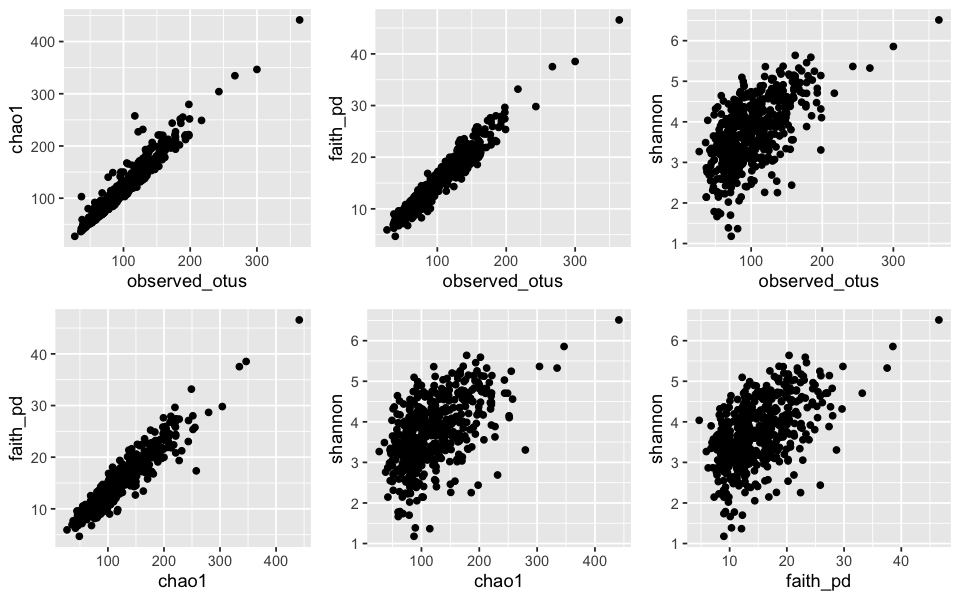

In [10]:
# Test to see if different alpha and beta metrics show the same result
options(repr.plot.height=5, repr.plot.width=8)
gg_mf <- ggplot(data=mf_alt_filt_final)            
grid.arrange(gg_mf + geom_point(aes(x=observed_otus, y=chao1))
             , gg_mf + geom_point(aes(x=observed_otus, y=faith_pd))
             , gg_mf + geom_point(aes(x=observed_otus, y=shannon))
             , gg_mf + geom_point(aes(x=chao1, y=faith_pd))
             , gg_mf + geom_point(aes(x=chao1, y=shannon))
             , gg_mf + geom_point(aes(x=faith_pd, y=shannon))  
             , nrow=2)

Of all the diversity metrics, it looks like shannon diversity is the only what that "looks" different-- probably because it takes into account evenness, unlike the others.

In [11]:
## Correlate beta diversity metrics with each other
mantel.rtest(as.dist(braycurtis_filt)
, as.dist(unweighted_unifrac_filt)
            , nrepet = 99)
mantel.rtest(as.dist(braycurtis_filt)
, as.dist(weighted_unifrac_filt)
            , nrepet = 99)
mantel.rtest(as.dist(unweighted_unifrac_filt)
, as.dist(weighted_unifrac_filt)
            , nrepet = 99)

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: 0.5111041 

Based on 99 replicates
Simulated p-value: 0.01 
Alternative hypothesis: greater 

      Std.Obs   Expectation      Variance 
 5.717075e+01 -5.822404e-04  8.010503e-05 

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: 0.510179 

Based on 99 replicates
Simulated p-value: 0.01 
Alternative hypothesis: greater 

     Std.Obs  Expectation     Variance 
4.872876e+01 4.369813e-05 1.095974e-04 

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: 0.3153188 

Based on 99 replicates
Simulated p-value: 0.01 
Alternative hypothesis: greater 

      Std.Obs   Expectation      Variance 
16.4545291001 -0.0007037919  0.0003688633 

It looks like all the distance matrices are correlated to each other, which is good. Now, let's see if distance and dispersion are correlated

Warning message:
“Removed 84 rows containing missing values (geom_point).”Warning message:
“Removed 84 rows containing missing values (geom_point).”Warning message:
“Removed 84 rows containing missing values (geom_point).”

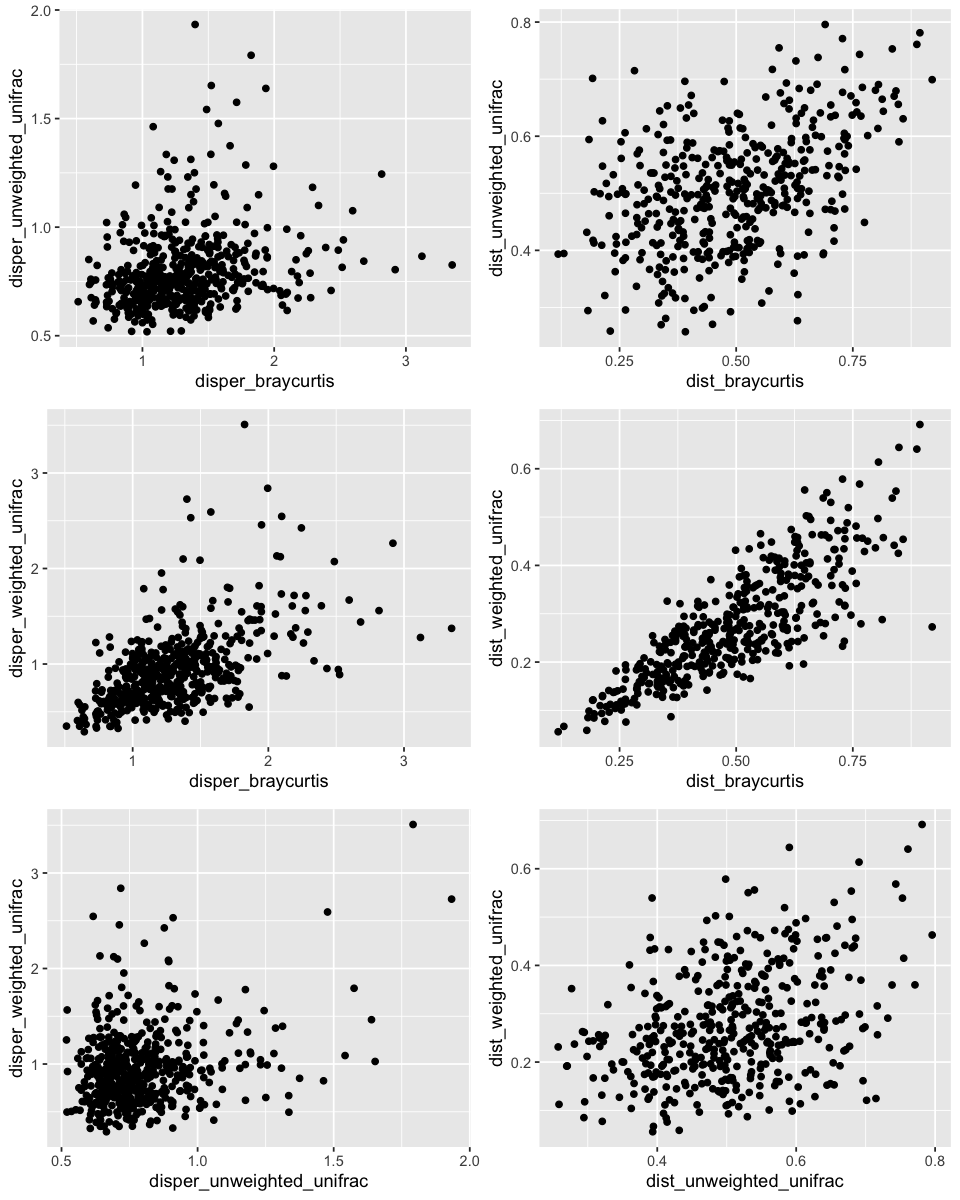

In [12]:
# Test to see if different beta metrics show the same result
options(repr.plot.height=10, repr.plot.width=8)
grid.arrange(gg_mf + geom_point(aes(x=disper_braycurtis, y=disper_unweighted_unifrac))
            , gg_mf + geom_point(aes(x=dist_braycurtis, y=dist_unweighted_unifrac))

             , gg_mf + geom_point(aes(x=disper_braycurtis, y=disper_weighted_unifrac))
            , gg_mf + geom_point(aes(x=dist_braycurtis, y=dist_weighted_unifrac))

             , gg_mf + geom_point(aes(x=disper_unweighted_unifrac, y=disper_weighted_unifrac))
             , gg_mf + geom_point(aes(x=dist_unweighted_unifrac, y=dist_weighted_unifrac))
             , nrow=3
            )

Warning message:
“Removed 33 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 33 rows containing missing values (geom_point).”

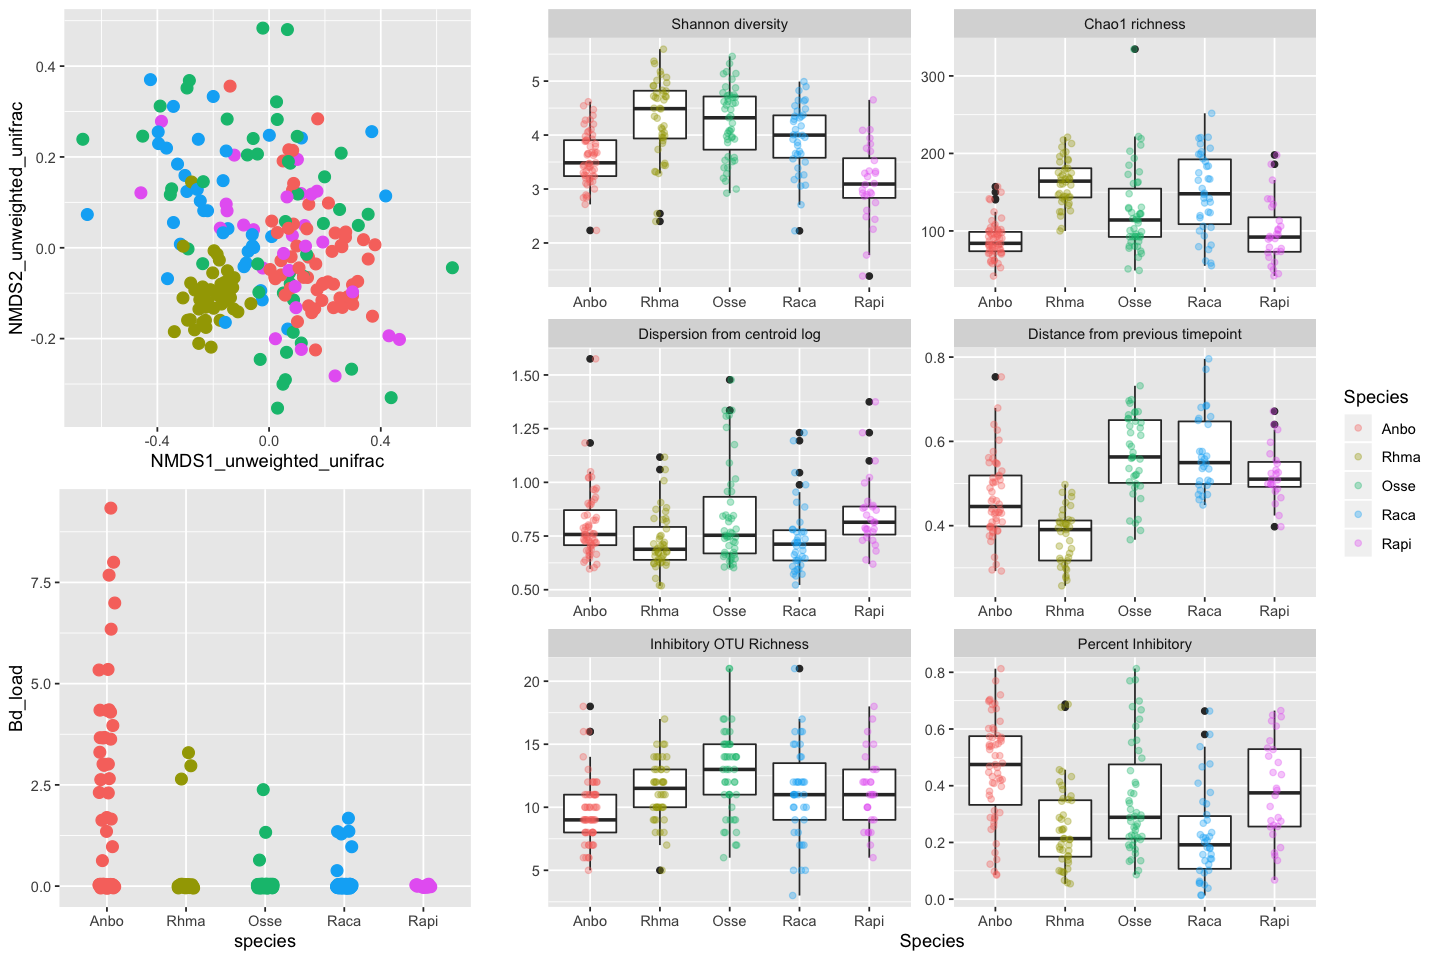

In [13]:
#### CURSORY GLANCE AT DATA ####
gg_NMDS <- mf_con %>%
    ggplot(aes(x=NMDS1_unweighted_unifrac, y=NMDS2_unweighted_unifrac)) +
    geom_point(aes(col=species), cex=3, show.legend = FALSE)
gg_infect <- mf_treat  %>%
    ggplot(aes(x=species, y=Bd_load)) +
    geom_point(aes(col=species), cex=3, position = position_jitter(width=0.1, height=0.05), show.legend = FALSE)

temp1a <-  mf_con %>%
    dplyr::select(species, shannon) %>%
    mutate(metric="Shannon_diversity") %>%
    rename(value=shannon)
temp1b <-  mf_con %>%
    dplyr::select(species, chao1) %>%
    mutate(metric="Chao1_richness") %>%
    rename(value=chao1)
temp2 <- mf_con %>%
    dplyr::select(species, inhibRich) %>%
    mutate(metric="Inhibitory_OTU_Richness")%>%
    rename(value=inhibRich)
temp3 <- mf_con %>%
    dplyr::select(species, percInhib) %>%
    mutate(metric="Percent_Inhibitory")%>%
    rename(value=percInhib)
temp4 <- mf_con %>%
    dplyr::select(species, disper_unweighted_unifrac) %>%
    mutate(metric="Dispersion_from_centroid_log")%>%
    rename(value=disper_unweighted_unifrac)
temp5 <- mf_con %>%
    dplyr::select(species, dist_unweighted_unifrac) %>%
    mutate(metric="Distance_from_previous_timepoint")%>%
    rename(value=dist_unweighted_unifrac)


gg_all <- rbind(temp1a,temp1b,temp2,temp3,temp4, temp5) %>%
    rename(Species=species) %>%
    mutate(Metric = gsub("_"," ",metric, fixed=TRUE)) %>%
    mutate(Metric = factor(Metric, levels=c("Shannon diversity","Chao1 richness","Dispersion from centroid log", "Distance from previous timepoint","Inhibitory OTU Richness","Percent Inhibitory"))) %>%
    ggplot(aes(x=Species, y=value)) +
    geom_boxplot() +
    geom_point(aes(col=Species), position = position_jitter(width=0.1, height=0), alpha=1/3)+
    facet_wrap(Metric~., scales = "free",nrow=3) +
    ylab("")+
    xlab("Species") 
lay <- rbind(c(1,2,2),
             c(3,2,2))

#+ fig.height=12, fig.width=10
options(repr.plot.height=8, repr.plot.width=12)
grid.arrange(gg_NMDS, gg_all, gg_infect, layout_matrix = lay)

In [14]:
print("Braycurtis")
adonis_composition_bc_timexspecies_con <- adonis2(dist(braycurtis_filt_con) ~ species*time, data=mf_con)
adonis_composition_bc_timexspecies_con
write.table(adonis_composition_bc_timexspecies_con
            , file="./6_Statistics/adonis_composition_bc_timexspecies_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)
print("Unweighted Unifrac")
adonis_composition_uwu_timexspecies_con <- adonis2(dist(unweighted_unifrac_filt_con) ~ species*time, data=mf_con)
adonis_composition_uwu_timexspecies_con
write.table(adonis_composition_uwu_timexspecies_con
            , file="./6_Statistics/adonis_composition_uwu_timexspecies_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)
print("Weighted Unifrac")
adonis_composition_wu_timexspecies_con <- adonis2(dist(weighted_unifrac_filt_con) ~ species*time, data=mf_con)
adonis_composition_wu_timexspecies_con
write.table(adonis_composition_wu_timexspecies_con
            , file="./6_Statistics/adonis_composition_wu_timexspecies_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


[1] "Braycurtis"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,461.46728,0.54909625,81.044417,0.001
time,1,41.03933,0.04883237,28.829855,0.001
species:time,4,44.66452,0.05314596,7.844132,0.001
Residual,206,293.24123,0.34892541,NA,NA
Total,215,840.41236,1.00000000,NA,NA


[1] "Unweighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,140.51617,0.43507514,46.090424,0.001
time,1,12.71518,0.03936955,16.682719,0.001
species:time,4,12.73016,0.03941594,4.175595,0.001
Residual,206,157.00838,0.48613937,NA,NA
Total,215,322.96989,1.00000000,NA,NA


[1] "Weighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,140.51617,0.43507514,46.090424,0.001
time,1,12.71518,0.03936955,16.682719,0.001
species:time,4,12.73016,0.03941594,4.175595,0.001
Residual,206,157.00838,0.48613937,NA,NA
Total,215,322.96989,1.00000000,NA,NA


In [15]:
print("Braycurtis")
adonis_composition_bc_timexspeciesxpabd_treat <- adonis2(dist(braycurtis_filt_treat) ~ species*time*PABD, data=mf_treat)
adonis_composition_bc_timexspeciesxpabd_treat
write.table(adonis_composition_bc_timexspeciesxpabd_treat
            , file="./6_Statistics/adonis_composition_bc_timexspeciesxpabd_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Unweighted Unifrac")
adonis_composition_uwu_timexspeciesxpabd_treat <- adonis2(dist(unweighted_unifrac_filt_treat) ~ species*time*PABD, data=mf_treat)
adonis_composition_uwu_timexspeciesxpabd_treat
write.table(adonis_composition_uwu_timexspeciesxpabd_treat
            , file="./6_Statistics/adonis_composition_uwu_timexspeciesxpabd_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Weighted Unifrac")
adonis_composition_wu_timexspeciesxpabd_treat <- adonis2(dist(weighted_unifrac_filt_treat) ~ species*time*PABD, data=mf_treat)
adonis_composition_wu_timexspeciesxpabd_treat
write.table(adonis_composition_wu_timexspeciesxpabd_treat
            , file="./6_Statistics/adonis_composition_wu_timexspeciesxpabd_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

[1] "Braycurtis"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,625.584701,0.421950636,66.573237,0.001
time,1,92.486081,0.062380939,39.368596,0.001
PABD,1,8.299677,0.005598049,3.532928,0.004
species:time,4,61.721768,0.041630716,6.568284,0.001
species:PABD,3,9.040943,0.006098026,1.282821,0.173
time:PABD,1,14.980506,0.010104202,6.376759,0.001
species:time:PABD,2,8.003703,0.005398418,1.703470,0.044
Residual,282,662.484252,0.446839014,NA,NA
Total,298,1482.601631,1.000000000,NA,NA


[1] "Unweighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,155.288528,0.325394687,40.480792,0.001
time,1,24.032886,0.050358989,25.059681,0.001
PABD,1,1.132054,0.002372129,1.180421,0.253
species:time,4,18.319874,0.038387830,4.775646,0.001
species:PABD,3,3.655380,0.007659557,1.270518,0.152
time:PABD,1,2.411559,0.005053230,2.514592,0.020
species:time:PABD,2,1.945682,0.004077020,1.014405,0.412
Residual,282,270.445333,0.566696558,NA,NA
Total,298,477.231296,1.000000000,NA,NA


[1] "Weighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,155.288528,0.325394687,40.480792,0.001
time,1,24.032886,0.050358989,25.059681,0.001
PABD,1,1.132054,0.002372129,1.180421,0.264
species:time,4,18.319874,0.038387830,4.775646,0.001
species:PABD,3,3.655380,0.007659557,1.270518,0.136
time:PABD,1,2.411559,0.005053230,2.514592,0.014
species:time:PABD,2,1.945682,0.004077020,1.014405,0.415
Residual,282,270.445333,0.566696558,NA,NA
Total,298,477.231296,1.000000000,NA,NA


In [56]:
### All data, see if there is an effect of exposure/bd on overall composition

print("Braycurtis")
adonis_composition_bc_timexspeciesxpabdxtreatment <- adonis2(dist(braycurtis_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:PABD, data=mf_alt_filt_final)
adonis_composition_bc_timexspeciesxpabdxtreatment
write.table(adonis_composition_bc_timexspeciesxpabdxtreatment
            , file="./6_Statistics/adonis_composition_bc_timexspeciesxpabdxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Unweighted Unifrac")
adonis_composition_uwu_timexspeciesxpabdxtreatment <- adonis2(dist(unweighted_unifrac_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:PABD, data=mf_alt_filt_final)
adonis_composition_uwu_timexspeciesxpabdxtreatment
write.table(adonis_composition_uwu_timexspeciesxpabdxtreatment
            , file="./6_Statistics/adonis_composition_uwu_timexspeciesxpabdxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Weighted Unifrac")
adonis_composition_wu_timexspeciesxpabdxtreatment <- adonis2(dist(weighted_unifrac_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:PABD, data=mf_alt_filt_final)
adonis_composition_wu_timexspeciesxpabdxtreatment
write.table(adonis_composition_wu_timexspeciesxpabdxtreatment
            , file="./6_Statistics/adonis_composition_wu_timexspeciesxpabdxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

[1] "Braycurtis"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,1759.80287,0.463323565,127.783086,0.001
time,1,211.44091,0.055668484,61.412725,0.001
prepost:Bd_exposure,3,69.05117,0.018179897,6.685273,0.001
prepost:Bd_exposure:PABD,1,19.23130,0.005063245,5.585704,0.001
Residual,505,1738.68952,0.457764809,NA,NA
Total,514,3798.21578,1.000000000,NA,NA


[1] "Unweighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,468.946614,0.374846682,84.889900,0.001
time,1,57.078811,0.045625242,41.330202,0.001
prepost:Bd_exposure,3,25.265218,0.020195440,6.098098,0.001
prepost:Bd_exposure:PABD,1,2.318127,0.001852966,1.678533,0.120
Residual,505,697.427019,0.557479670,NA,NA
Total,514,1251.035789,1.000000000,NA,NA


[1] "Weighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,653.3744,0.249681365,45.529466,0.001
time,1,115.7513,0.044233360,32.263862,0.001
prepost:Bd_exposure,3,23.0808,0.008820128,2.144470,0.014
prepost:Bd_exposure:PABD,1,12.8652,0.004916326,3.585974,0.006
Residual,505,1811.7612,0.692348820,NA,NA
Total,514,2616.8330,1.000000000,NA,NA


In [57]:
### All data, see if there is an effect of exposure/bd on overall composition
print("Braycurtis")
adonis_composition_bc_timexspeciesxbdloadxtreatment <- adonis2(dist(braycurtis_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:Bd_load, data=mf_alt_filt_final)
adonis_composition_bc_timexspeciesxbdloadxtreatment
write.table(adonis_composition_bc_timexspeciesxbdloadxtreatment
            , file="./6_Statistics/adonis_composition_bc_timexspeciesxbdloadxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Unweighted Unifrac")
adonis_composition_uwu_timexspeciesxbdloadxtreatment <- adonis2(dist(unweighted_unifrac_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:Bd_load, data=mf_alt_filt_final)
adonis_composition_uwu_timexspeciesxbdloadxtreatment
write.table(adonis_composition_uwu_timexspeciesxbdloadxtreatment
            , file="./6_Statistics/adonis_composition_uwu_timexspeciesxbdloadxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

print("Weighted Unifrac")
adonis_composition_wu_timexspeciesxbdloadxtreatment <- adonis2(dist(weighted_unifrac_filt) ~ species + time + prepost:Bd_exposure + prepost:Bd_exposure:Bd_load, data=mf_alt_filt_final)
adonis_composition_wu_timexspeciesxbdloadxtreatment
write.table(adonis_composition_wu_timexspeciesxbdloadxtreatment
            , file="./6_Statistics/adonis_composition_wu_timexspeciesxbdloadxtreatment.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

[1] "Braycurtis"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,1759.80287,0.463323565,128.935910,0.001
time,1,211.44091,0.055668484,61.966773,0.001
prepost:Bd_exposure,3,69.05117,0.018179897,6.745586,0.001
prepost:Bd_exposure:Bd_load,1,34.77702,0.009156147,10.192066,0.001
Residual,505,1723.14380,0.453671907,NA,NA
Total,514,3798.21578,1.000000000,NA,NA


[1] "Unweighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,468.946614,0.374846682,84.988269,0.001
time,1,57.078811,0.045625242,41.378094,0.001
prepost:Bd_exposure,3,25.265218,0.020195440,6.105164,0.001
prepost:Bd_exposure:Bd_load,1,3.125354,0.002498213,2.265660,0.041
Residual,505,696.619792,0.556834423,NA,NA
Total,514,1251.035789,1.000000000,NA,NA


[1] "Weighted Unifrac"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,653.37443,0.249681365,45.997061,0.001
time,1,115.75132,0.044233360,32.595217,0.001
prepost:Bd_exposure,3,23.08080,0.008820128,2.166495,0.021
prepost:Bd_exposure:Bd_load,1,31.28313,0.011954578,8.809235,0.001
Residual,505,1793.34329,0.685310569,NA,NA
Total,514,2616.83297,1.000000000,NA,NA


# Preliminary stats on broad patterns

## Richness/diversity and time
Does richness change over time in control individuals?

### Observed otus, chao1, faith's PD, and shannon

In [16]:
### Observed_otus
# Type I ANOVA to see if interactions present
anova(lm(log(observed_otus) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_richness_logobsotu_speciesxtime_con <- Anova(lm(log(observed_otus) ~ species*time, data=mf_con), type=3)
anova_richness_logobsotu_speciesxtime_con

write.table(anova_richness_logobsotu_speciesxtime_con
            , file="./6_Statistics/anova_richness_logobsotu_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Chao1
# Type I ANOVA to see if interactions present
anova(lm(log(chao1) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_richness_logchao1_speciesxtime_con <- Anova(lm(log(chao1) ~ species*time, data=mf_con), type=3)
anova_richness_logchao1_speciesxtime_con

write.table(anova_richness_logchao1_speciesxtime_con
            , file="./6_Statistics/anova_richness_logchao1_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Faith's PD
# Type I ANOVA to see if interactions present
anova(lm(log(faith_pd) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_richness_logfaithpd_speciesxtime_con <- Anova(lm(log(faith_pd) ~ species*time, data=mf_con), type=3)
anova_richness_logfaithpd_speciesxtime_con

write.table(anova_richness_logfaithpd_speciesxtime_con
            , file="./6_Statistics/anova_richness_logfaithpd_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Shannon
# Type I ANOVA to see if interactions present
anova(lm(shannon ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_richness_shannon_speciesxtime_con <- Anova(lm(shannon ~ species*time, data=mf_con), type=3)
anova_richness_shannon_speciesxtime_con

write.table(anova_richness_shannon_speciesxtime_con
            , file="./6_Statistics/anova_richness_shannon_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,11.9904552,2.99761379,36.237632,6.410584e-23
time,1,0.4344881,0.43448807,5.252451,2.292659e-02
species:time,4,0.7500439,0.18751097,2.266788,6.323145e-02
Residuals,206,17.0405295,0.08272102,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),260.28358055,1,3146.5229773,9.400378e-127
species,3.15632930,4,9.5390791,4.279910e-07
time,0.01771548,1,0.2141594,6.440151e-01
species:time,0.75004388,4,2.2667875,6.323145e-02
Residuals,17.04052949,206,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,12.6020732,3.1505183,29.905350,1.282782e-19
time,1,0.3462987,0.3462987,3.287137,7.128022e-02
species:time,4,0.9050430,0.2262608,2.147712,7.619630e-02
Residuals,206,21.7020290,0.1053497,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),284.43636374,1,2699.9268621,2.345785e-120
species,3.76685587,4,8.9389374,1.124425e-06
time,0.05078522,1,0.4820635,4.882714e-01
species:time,0.90504301,4,2.1477123,7.619630e-02
Residuals,21.70202895,206,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,8.2882323,2.07205807,27.83758,1.736426e-18
time,1,0.9730478,0.97304776,13.07265,3.767638e-04
species:time,4,0.6753651,0.16884127,2.26834,6.307730e-02
Residuals,206,15.3333717,0.07443384,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),79.71311001,1,1070.9256213,1.498127e-83
species,2.73480307,4,9.1853482,7.557138e-07
time,0.03175822,1,0.4266638,5.143589e-01
species:time,0.67536507,4,2.2683400,6.307730e-02
Residuals,15.33337174,206,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,36.163364,9.0408409,24.276036,1.802228e-16
time,1,1.810998,1.8109979,4.862805,2.854795e-02
species:time,4,6.577704,1.6444260,4.415534,1.909615e-03
Residuals,206,76.718177,0.3724183,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),184.46887119,1,495.3270381,1.041438e-56
species,4.19586425,4,2.8166338,2.631657e-02
time,0.06433537,1,0.1727503,6.781116e-01
species:time,6.57770404,4,4.4155345,1.909615e-03
Residuals,76.71817717,206,NA,NA


All metrics show sig effect of time, except chao1 and shannon. It's p=0.07 for chao1, nd 0.6 for shannon if you take into account species:time interactions.
All metrics show NO effect of interaction, except shannon. 

This suggests that evenness changes differently in species, but richness doesn't necessarily.

In [17]:
### Observed otus
# Type I ANOVA to see if interactions present
anova(lm(log(observed_otus) ~ species*time, data=mf_treat))
# Type III ANOVA (regardless of interactions)
anova_richness_logobsotu_speciesxtime_treat <- Anova(lm(log(observed_otus) ~ species*time, data=mf_treat), type=3)
anova_richness_logobsotu_speciesxtime_treat

write.table(anova_richness_logobsotu_speciesxtime_treat
            , file="./6_Statistics/anova_richness_logobsotu_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Chao1
# Type I ANOVA to see if interactions present
anova(lm(log(chao1) ~ species*time, data=mf_treat))
# Type III ANOVA when interactions ARE present
anova_richness_logchao1_speciesxtime_treat <- Anova(lm(log(chao1) ~ species*time, data=mf_treat), type=3)
anova_richness_logchao1_speciesxtime_treat

write.table(anova_richness_logchao1_speciesxtime_treat
            , file="./6_Statistics/anova_richness_logchao1_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Faith's PD
# Type I ANOVA to see if interactions present
anova(lm(log(faith_pd) ~ species*time, data=mf_treat))
# Type III ANOVA when interactions ARE present
anova_richness_logfaithpd_speciesxtime_treat <- Anova(lm(log(faith_pd) ~ species*time, data=mf_treat), type=3)
anova_richness_logfaithpd_speciesxtime_treat

write.table(anova_richness_logfaithpd_speciesxtime_treat
            , file="./6_Statistics/anova_richness_logfaithpd_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Shannon
# Type I ANOVA to see if interactions present
anova(lm(shannon ~ species*time, data=mf_treat))
# Type III ANOVA when interactions ARE present
anova_richness_shannon_speciesxtime_treat <- Anova(lm(shannon ~ species*time, data=mf_treat), type=3)
anova_richness_shannon_speciesxtime_treat

write.table(anova_richness_logobsotu_speciesxtime_treat
            , file="./6_Statistics/anova_richness_shannon_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,18.8285412,4.70713530,52.871513,2.139980e-33
time,1,0.1933914,0.19339141,2.172212,1.416124e-01
species:time,4,2.6064823,0.65162056,7.319136,1.257635e-05
Residuals,289,25.7295851,0.08902971,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),343.25413860,1,3855.5011876,3.644978e-169
species,5.46961769,4,15.3589681,2.110071e-11
time,0.05890139,1,0.6615925,4.166679e-01
species:time,2.60648225,4,7.3191364,1.257635e-05
Residuals,25.72958514,289,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,19.9008857,4.9752214,44.728138,3.243947e-29
time,1,0.1253726,0.1253726,1.127122,2.892764e-01
species:time,4,2.2266499,0.5566625,5.004496,6.493386e-04
Residuals,289,32.1461848,0.1112325,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),370.1334936,1,3327.5668766,1.303061e-160
species,5.9807303,4,13.4419611,4.638392e-10
time,0.0558652,1,0.5022382,4.790896e-01
species:time,2.2266499,4,5.0044961,6.493386e-04
Residuals,32.1461848,289,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,11.2222018,2.80555045,41.434224,1.919050e-27
time,1,0.9734825,0.97348251,14.377033,1.821602e-04
species:time,4,2.4754767,0.61886919,9.139869,5.765842e-07
Residuals,289,19.5684631,0.06771094,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),104.09272878,1,1537.310235,1.024371e-117
species,5.38450014,4,19.880464,1.792252e-14
time,0.08961887,1,1.323551,2.509068e-01
species:time,2.47547674,4,9.139869,5.765842e-07
Residuals,19.56846310,289,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,28.1682931,7.0420733,12.9246404,1.077889e-09
time,1,0.1058364,0.1058364,0.1942464,6.597351e-01
species:time,4,21.6232910,5.4058227,9.9215547,1.551469e-07
Residuals,289,157.4635047,0.5448564,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),257.601313,1,472.787518,8.882566e-63
species,16.232638,4,7.448127,1.009971e-05
time,3.655725,1,6.709520,1.007619e-02
species:time,21.623291,4,9.921555,1.551469e-07
Residuals,157.463505,289,NA,NA


In treatment, all metrics shows a signficiant interaction of species:time.
In Shannon, it also shows a significant effect of time. No other metric shows time alone, after accounting for species effects.

## Dispersion between individuals at each time point
Does dispersion change over time?
### Distance using bray-curtis, unweighted unifrac, weighted unifrac


In [18]:
### Braycurtis
# Type I ANOVA to see if interactions present
anova(lm(log(disper_braycurtis) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_disper_braycurtis_speciesxtime_con <- Anova(lm(log(disper_braycurtis) ~ species*time, data=mf_con), type=3)

anova_disper_braycurtis_speciesxtime_con

write.table(anova_disper_braycurtis_speciesxtime_con
            , file="./6_Statistics/anova_disper_braycurtis_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
anova(lm(log(disper_unweighted_unifrac) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_disper_unweighted_unifrac_speciesxtime_con <- Anova(lm(log(disper_unweighted_unifrac) ~ species*time, data=mf_con), type=3)

anova_disper_unweighted_unifrac_speciesxtime_con

write.table(anova_disper_unweighted_unifrac_speciesxtime_con
            , file="./6_Statistics/anova_disper_unweighted_unifrac_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
anova(lm(log(disper_weighted_unifrac) ~ species*time, data=mf_con))
# Type III ANOVA (regardless of interactions)
anova_disper_weighted_unifrac_speciesxtime_con <- Anova(lm(log(disper_weighted_unifrac) ~ species*time, data=mf_con), type=3)

anova_disper_weighted_unifrac_speciesxtime_con

write.table(anova_disper_weighted_unifrac_speciesxtime_con
            , file="./6_Statistics/anova_disper_weighted_unifrac_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)




,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,2.1893593,0.54733983,9.964876,2.165226e-07
time,1,1.7510348,1.75103475,31.879362,5.393798e-08
species:time,4,0.4798391,0.11995979,2.183989,7.199838e-02
Residuals,206,11.3149428,0.05492691,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.4144175,1,7.544890,6.551113e-03
species,1.3880259,4,6.317605,8.170592e-05
time,1.4991669,1,27.293853,4.267143e-07
species:time,0.4798391,4,2.183989,7.199838e-02
Residuals,11.3149428,206,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,0.7727508,0.19318769,5.293078,0.0004456608
time,1,0.2804246,0.28042463,7.683251,0.0060841695
species:time,4,0.4788704,0.11971759,3.280098,0.0123981417
Residuals,206,7.5186240,0.03649817,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.6113805,1,44.1496175,2.664420e-10
species,0.1005303,4,0.6885978,6.006027e-01
time,0.1875224,1,5.1378565,2.444819e-02
species:time,0.4788704,4,3.2800980,1.239814e-02
Residuals,7.5186240,206,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,0.6829631,0.1707408,1.412053,2.311559e-01
time,1,2.0841929,2.0841929,17.236598,4.830544e-05
species:time,4,2.0533411,0.5133353,4.245362,2.531034e-03
Residuals,206,24.9088442,0.1209167,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.836874,1,40.001697,1.550409e-09
species,2.561515,4,5.296032,4.434827e-04
time,2.877433,1,23.796821,2.139305e-06
species:time,2.053341,4,4.245362,2.531034e-03
Residuals,24.908844,206,NA,NA


Time as a strong effect on dispersion over time. The interaction between species and time is only significant in metrics that include bacterial phylogeny, so perhaps certain species have more "redundancy" with similar microbes than others.

In [19]:
### Braycurtis
# Type I ANOVA to see if interactions present
anova(lm(log(disper_braycurtis) ~ species*time, data=mf_treat))
# Type III ANOVA (regardless of interactions)
anova_disper_braycurtis_speciesxtime_treat <- Anova(lm(log(disper_braycurtis) ~ species*time, data=mf_treat), type=3)

anova_disper_braycurtis_speciesxtime_treat

write.table(anova_disper_braycurtis_speciesxtime_treat
            , file="./6_Statistics/anova_disper_braycurtis_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
anova(lm(log(disper_unweighted_unifrac) ~ species*time, data=mf_treat))
# Type III ANOVA (regardless of interactions)
anova_disper_unweighted_unifrac_speciesxtime_treat <- Anova(lm(log(disper_unweighted_unifrac) ~ species*time, data=mf_treat), type=3)

anova_disper_unweighted_unifrac_speciesxtime_treat

write.table(anova_disper_unweighted_unifrac_speciesxtime_treat
            , file="./6_Statistics/anova_disper_unweighted_unifrac_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
anova(lm(log(disper_weighted_unifrac) ~ species*time, data=mf_treat))
# Type III ANOVA (regardless of interactions)
anova_disper_weighted_unifrac_speciesxtime_treat <- Anova(lm(log(disper_weighted_unifrac) ~ species*time, data=mf_treat), type=3)

anova_disper_weighted_unifrac_speciesxtime_treat

write.table(anova_disper_weighted_unifrac_speciesxtime_treat
            , file="./6_Statistics/anova_disper_weighted_unifrac_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)




,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,2.467272,0.61681800,7.811700,5.446694e-06
time,1,1.815273,1.81527346,22.989557,2.611200e-06
species:time,4,1.067074,0.26676845,3.378493,1.010365e-02
Residuals,289,22.819667,0.07896079,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.06560050,1,0.8307985,3.628014e-01
species,0.09274091,4,0.2936297,8.820037e-01
time,2.17718710,1,27.5730173,2.937161e-07
species:time,1.06707381,4,3.3784929,1.010365e-02
Residuals,22.81966697,289,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,0.2562521,0.06406303,1.729188,0.1435383850
time,1,0.4492347,0.44923467,12.125734,0.0005742073
species:time,4,0.2323688,0.05809221,1.568024,0.1828666183
Residuals,289,10.7068835,0.03704804,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.7236399,1,46.524457,5.295493e-11
species,0.1755604,4,1.184681,3.176415e-01
time,0.1958597,1,5.286641,2.220275e-02
species:time,0.2323688,4,1.568024,1.828666e-01
Residuals,10.7068835,289,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,1.5413511,0.38533776,2.5622900,0.038674723
time,1,2.0634892,2.06348922,13.7210993,0.000254017
species:time,4,0.3484022,0.08710056,0.5791721,0.677963489
Residuals,289,43.4621434,0.15038804,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.7374543,1,4.9036764,0.02757977
species,0.4572924,4,0.7601874,0.55193491
time,0.8098590,1,5.3851294,0.02100518
species:time,0.3484022,4,0.5791721,0.67796349
Residuals,43.4621434,289,NA,NA


As with control, time significantly affects dispersion. However, unlike controls, the interaction between species and time is NOT significant with phylogenetic methods and IS significant with non-phylogenetic methods.

## Distance between time points
Does turnover rate change over time?
### Distance using bray-curtis, unweighted unifrac, weighted unifrac
I'm using gamma because glm doesn't have a beta family

In [20]:
### Braycurtis
# Type I ANOVA to see if interactions present
Anova(glm(dist_braycurtis ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_dist_braycurtis_speciesxtime_con <- Anova(glm(dist_braycurtis ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)

anova_dist_braycurtis_speciesxtime_con

write.table(anova_dist_braycurtis_speciesxtime_con
            , file="./6_Statistics/anova_dist_braycurtis_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
Anova(glm(dist_unweighted_unifrac ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_dist_unweighted_unifrac_speciesxtime_con <- Anova(glm(dist_unweighted_unifrac ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)

anova_dist_unweighted_unifrac_speciesxtime_con

write.table(anova_dist_unweighted_unifrac_speciesxtime_con
            , file="./6_Statistics/anova_dist_unweighted_unifrac_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


### Weighted Unifrac
# Type I ANOVA to see if interactions present
Anova(glm(dist_weighted_unifrac ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_dist_weighted_unifrac_speciesxtime_con <- Anova(glm(dist_weighted_unifrac ~ species*time, data=mf_con, family=Gamma(link="identity")), type=3)

anova_dist_weighted_unifrac_speciesxtime_con

write.table(anova_dist_weighted_unifrac_speciesxtime_con
            , file="./6_Statistics/anova_dist_weighted_unifrac_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)





,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,12.1966953,4,0.01594698
time,0.4504406,1,0.50212580
species:time,1.1283819,4,0.88974336


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,12.1966953,4,0.01594698
time,0.4504406,1,0.50212580
species:time,1.1283819,4,0.88974336


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,21.020047,4,0.0003137841
time,1.129053,1,0.2879773718
species:time,3.987593,4,0.4076876189


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,21.020047,4,0.0003137841
time,1.129053,1,0.2879773718
species:time,3.987593,4,0.4076876189


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,8.874591,4,0.06431169
time,2.295000,1,0.12979119
species:time,1.512674,4,0.82439412


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,8.874591,4,0.06431169
time,2.295000,1,0.12979119
species:time,1.512674,4,0.82439412


Neither time nor interaction are significant in everything EXCEPT unweighted unifrac-- in unweighted unifrac, there is a significant effect of time on distance in control individuals. 

In [21]:
### Braycurtis
# Type I ANOVA to see if interactions present
Anova(glm(dist_braycurtis ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_dist_braycurtis_speciesxtime_treat <- Anova(glm(dist_braycurtis ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)

anova_dist_braycurtis_speciesxtime_treat

write.table(anova_dist_braycurtis_speciesxtime_treat
            , file="./6_Statistics/anova_dist_braycurtis_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)

### Unweighted Unifrac
# Type I ANOVA to see if interactions present
Anova(glm(dist_unweighted_unifrac ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)
# Type II ANOVA when interactions ARE NOT present
anova_dist_unweighted_unifrac_speciesxtime_treat <- Anova(glm(dist_unweighted_unifrac ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)

anova_dist_unweighted_unifrac_speciesxtime_treat

write.table(anova_dist_unweighted_unifrac_speciesxtime_treat
            , file="./6_Statistics/anova_dist_unweighted_unifrac_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


### Weighted Unifrac
# Type I ANOVA to see if interactions present
Anova(glm(dist_weighted_unifrac ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_dist_weighted_unifrac_speciesxtime_treat <- Anova(glm(dist_weighted_unifrac ~ species*time, data=mf_treat, family=Gamma(link="identity")), type=3)

anova_dist_weighted_unifrac_speciesxtime_treat

write.table(anova_dist_weighted_unifrac_speciesxtime_treat
            , file="./6_Statistics/anova_dist_weighted_unifrac_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)





,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,3.92008261,4,0.4169295
time,0.09603303,1,0.7566431
species:time,1.54284416,4,0.8190260


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,3.92008261,4,0.4169295
time,0.09603303,1,0.7566431
species:time,1.54284416,4,0.8190260


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,20.2573187,4,0.0004442444
time,0.3390161,1,0.5603977053
species:time,6.2566079,4,0.1807867213


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,20.2573187,4,0.0004442444
time,0.3390161,1,0.5603977053
species:time,6.2566079,4,0.1807867213


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,6.5001396,4,0.1647816
time,0.3022183,1,0.5824951
species:time,1.9117159,4,0.7519924


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,6.5001396,4,0.1647816
time,0.3022183,1,0.5824951
species:time,1.9117159,4,0.7519924


Results are same as control; no effect of time or interaction on anything except unweighted unifrac metric.

## Inhibitory richness
Does richness of inhibitory OTUs change over time?

In [22]:
# Type I ANOVA to see if interactions present
Anova(glm(inhibRich ~ species*time, data=mf_con, family=poisson(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_inhibRich_speciesxtime_con <- Anova(glm(inhibRich ~ species*time, data=mf_con, family=poisson(link="identity")), type=3)

anova_inhibRich_speciesxtime_con

write.table(anova_inhibRich_speciesxtime_con
            , file="./6_Statistics/anova_inhibRich_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,25.883540,4,3.340247e-05
time,9.813418,1,1.732432e-03
species:time,27.334764,4,1.700920e-05


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,25.883540,4,3.340247e-05
time,9.813418,1,1.732432e-03
species:time,27.334764,4,1.700920e-05


In [23]:
# Type I ANOVA to see if interactions present
Anova(glm(inhibRich ~ species*time, data=mf_treat, family=poisson(link="identity")), type=3)
# Type III ANOVA (regardless of interactions)
anova_inhibRich_speciesxtime_treat <- Anova(glm(inhibRich ~ species*time, data=mf_treat, family=poisson(link="identity")), type=3)

anova_inhibRich_speciesxtime_treat

write.table(anova_inhibRich_speciesxtime_treat
            , file="./6_Statistics/anova_inhibRich_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,38.899191,4,7.308574e-08
time,8.706974,1,3.169950e-03
species:time,23.355761,4,1.074998e-04


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,38.899191,4,7.308574e-08
time,8.706974,1,3.169950e-03
species:time,23.355761,4,1.074998e-04


Both control and treatment show significant effects of time and interaction for inhibitory OTU richness

## Percent inhibitory
Does percent inhibitory change over time?

In [24]:
# Type I ANOVA to see if interactions present
Anova(glm(percInhib ~ species*time, data=mf_con, family=Gamma), type=3)
# Type III ANOVA (regardless of interactions)
anova_percInhib_speciesxtime_con <- Anova(glm(percInhib ~ species*time, data=mf_con, family=Gamma), type=3)

anova_percInhib_speciesxtime_con

write.table(anova_percInhib_speciesxtime_con
            , file="./6_Statistics/anova_percInhib_speciesxtime_con.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,77.452492,4,6.032296e-16
time,1.957125,1,1.618211e-01
species:time,40.898113,4,2.821602e-08


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,77.452492,4,6.032296e-16
time,1.957125,1,1.618211e-01
species:time,40.898113,4,2.821602e-08


In [25]:
# Type I ANOVA to see if interactions present
Anova(glm(percInhib ~ species*time, data=mf_treat, family=Gamma), type=3)
# Type III ANOVA (regardless of interactions)
anova_percInhib_speciesxtime_treat <- Anova(glm(percInhib ~ species*time, data=mf_treat, family=), type=3)

anova_percInhib_speciesxtime_treat

write.table(anova_percInhib_speciesxtime_treat
            , file="./6_Statistics/anova_percInhib_speciesxtime_treat.txt"
            , quote=FALSE, sep="\t", col.names=NA, row.names=TRUE)


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,80.0819282,4,1.673585e-16
time,0.2080167,1,6.483264e-01
species:time,73.3364783,4,4.478797e-15


,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,79.6476800,4,2.068426e-16
time,0.3136464,1,5.754512e-01
species:time,73.5543851,4,4.028078e-15


#### Make table of statistical results
First, make a function to extract results.


In [26]:
get_stats <- function(stat_test, variable) {
    indep_var <- rownames(stat_test)
stat_col <- colnames(stat_test)
if ("LR Chisq" %in% stat_col) {
    stat_val <- stat_test[variable,"LR Chisq"]
    df_val <- stat_test[variable,"Df"]
    stat_phrase <- paste0("LR Chisq(",df_val,")=",round(stat_val,3))
    
    p_val <- stat_test[variable, "Pr(>Chisq)"]
    test <- "LR Chisq"
} else if ("F value" %in% stat_col) {
    stat_val <- stat_test[variable,"F value"]
    df_val <- stat_test[variable,"Df"]
    df_res <- stat_test["Residuals","Df"]
    stat_phrase <- paste0("F(",df_val,",",df_res,")=",round(stat_val,3))
    
    p_val <- stat_test[variable, "Pr(>F)"]
    test <- "ANOVA"

} else {
    print("NO TEST MATCHING")
}
if ( p_val < 0.001 ) {
    p_phrase <- "p<0.001"
} else {
    p_phrase <- paste0("p=",round(p_val,3))

}

output<- list()
output$p.phrase <- p_phrase
output$stat_phrase <- stat_phrase
output$all <- paste0(p_phrase,", ", stat_phrase)
output$test <- test
return(output)
}



In [27]:
stats_table <- data.frame("Microbial Community Trait"=c(
                                                        "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Dispersion"
                                                       , "Dispersion"
                                                       , "Dispersion"
                                                       , "Distance"
                                                       , "Distance"
                                                       , "Distance"
                                                       , "Inhibitory Richness"
                                                       , "Percent Inhibitory"
                                                       )
                          , "Metric"=c(
                                       "Observed otus"
                                      , "Chao1"
                                      , "Faith's PD"
                                      , "Shannon"
                                      , "Bray-curtis"
                                      , "Unweighted Unifrac"
                                      , "Weighted Unifrac"
                                      , "Bray-curtis"
                                      , "Unweighted Unifrac"
                                      , "Weighted Unifrac"
                                      , "Count"
                                      , "Proportion"
                                      )
                         , "Test"=NA
                         , "Control_species"=NA
                         , "Control_time"=NA
                         , "Control_speciesxtime"=NA
                         , "Treatment_species"=NA
                         , "Treatment_time"=NA
                         , "Treatment_speciesxtime"=NA)
# List of all tests
all_tests <- c("anova_richness_logobsotu_speciesxtime"
,"anova_richness_logchao1_speciesxtime"
,"anova_richness_logfaithpd_speciesxtime"
,"anova_richness_shannon_speciesxtime"
,"anova_disper_braycurtis_speciesxtime"
,"anova_disper_unweighted_unifrac_speciesxtime"
,"anova_disper_weighted_unifrac_speciesxtime"
,"anova_dist_braycurtis_speciesxtime"
,"anova_dist_unweighted_unifrac_speciesxtime"
,"anova_dist_weighted_unifrac_speciesxtime"
,"anova_inhibRich_speciesxtime"
,"anova_percInhib_speciesxtime")
# Make these the rownames
rownames(stats_table) <- all_tests



In [28]:

for ( t in all_tests ) {
    for ( group in c("con","treat") ) {
        full_group <- ifelse (group=="con","Control_","Treatment_")
        for ( variable in c("species","time","speciesxtime")) {
            if ( variable == "speciesxtime") {
                varget = "species:time"
            } else {
                varget = variable
            }
            temp_stats <- get_stats(stat_test = get(paste0(t,"_",group)), varget)
            stats_table[t,"Test"] <- temp_stats$test
            stats_table[t,paste0(full_group,variable)] <- temp_stats$all
        }
    }
}

stats_table
write.table(stats_table, file="./6_Statistics/general_patterns_stats.txt", row.names = FALSE, col.names = TRUE, quote = FALSE, sep="\t")


,Microbial.Community.Trait,Metric,Test,Control_species,Control_time,Control_speciesxtime,Treatment_species,Treatment_time,Treatment_speciesxtime
,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
anova_richness_logobsotu_speciesxtime,Alpha diversity,Observed otus,ANOVA,"p<0.001, F(4,206)=9.539","p=0.644, F(1,206)=0.214","p=0.063, F(4,206)=2.267","p<0.001, F(4,289)=15.359","p=0.417, F(1,289)=0.662","p<0.001, F(4,289)=7.319"
anova_richness_logchao1_speciesxtime,Alpha diversity,Chao1,ANOVA,"p<0.001, F(4,206)=8.939","p=0.488, F(1,206)=0.482","p=0.076, F(4,206)=2.148","p<0.001, F(4,289)=13.442","p=0.479, F(1,289)=0.502","p<0.001, F(4,289)=5.004"
anova_richness_logfaithpd_speciesxtime,Alpha diversity,Faith's PD,ANOVA,"p<0.001, F(4,206)=9.185","p=0.514, F(1,206)=0.427","p=0.063, F(4,206)=2.268","p<0.001, F(4,289)=19.88","p=0.251, F(1,289)=1.324","p<0.001, F(4,289)=9.14"
anova_richness_shannon_speciesxtime,Alpha diversity,Shannon,ANOVA,"p=0.026, F(4,206)=2.817","p=0.678, F(1,206)=0.173","p=0.002, F(4,206)=4.416","p<0.001, F(4,289)=7.448","p=0.01, F(1,289)=6.71","p<0.001, F(4,289)=9.922"
anova_disper_braycurtis_speciesxtime,Dispersion,Bray-curtis,ANOVA,"p<0.001, F(4,206)=6.318","p<0.001, F(1,206)=27.294","p=0.072, F(4,206)=2.184","p=0.882, F(4,289)=0.294","p<0.001, F(1,289)=27.573","p=0.01, F(4,289)=3.378"
anova_disper_unweighted_unifrac_speciesxtime,Dispersion,Unweighted Unifrac,ANOVA,"p=0.601, F(4,206)=0.689","p=0.024, F(1,206)=5.138","p=0.012, F(4,206)=3.28","p=0.318, F(4,289)=1.185","p=0.022, F(1,289)=5.287","p=0.183, F(4,289)=1.568"
anova_disper_weighted_unifrac_speciesxtime,Dispersion,Weighted Unifrac,ANOVA,"p<0.001, F(4,206)=5.296","p<0.001, F(1,206)=23.797","p=0.003, F(4,206)=4.245","p=0.552, F(4,289)=0.76","p=0.021, F(1,289)=5.385","p=0.678, F(4,289)=0.579"
anova_dist_braycurtis_speciesxtime,Distance,Bray-curtis,LR Chisq,"p=0.016, LR Chisq(4)=12.197","p=0.502, LR Chisq(1)=0.45","p=0.89, LR Chisq(4)=1.128","p=0.417, LR Chisq(4)=3.92","p=0.757, LR Chisq(1)=0.096","p=0.819, LR Chisq(4)=1.543"
anova_dist_unweighted_unifrac_speciesxtime,Distance,Unweighted Unifrac,LR Chisq,"p<0.001, LR Chisq(4)=21.02","p=0.288, LR Chisq(1)=1.129","p=0.408, LR Chisq(4)=3.988","p<0.001, LR Chisq(4)=20.257","p=0.56, LR Chisq(1)=0.339","p=0.181, LR Chisq(4)=6.257"


In [29]:
anova_disper_braycurtis_speciesxtime_treat

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.06560050,1,0.8307985,3.628014e-01
species,0.09274091,4,0.2936297,8.820037e-01
time,2.17718710,1,27.5730173,2.937161e-07
species:time,1.06707381,4,3.3784929,1.010365e-02
Residuals,22.81966697,289,NA,NA


# Correlating prior microbial community traits to future Bd infection

In [30]:
# First, find out if any metrics are correlated to each other
all_metrics <- c("p_observed_otus"
 , "p_chao1"
 , "p_faith_pd"
 , "p_shannon"
 , "p_disper_braycurtis"
 , "p_disper_unweighted_unifrac"
 , "p_disper_weighted_unifrac"
 , "p_dist_braycurtis"
 , "p_dist_unweighted_unifrac"
 , "p_dist_weighted_unifrac"
 , "p_percInhib"
 , "p_inhibRich")

all_p_ponly <- all_p %>%
dplyr::select(one_of(all_metrics))

all_corr <- cor(all_p_ponly)
all_corr


,p_observed_otus,p_chao1,p_faith_pd,p_shannon,p_disper_braycurtis,p_disper_unweighted_unifrac,p_disper_weighted_unifrac,p_dist_braycurtis,p_dist_unweighted_unifrac,p_dist_weighted_unifrac,p_percInhib,p_inhibRich
p_observed_otus,1.00000000,0.96689155,0.949756363,0.76945006,-0.1671852,0.11511247,-0.161693631,-0.058242865,-0.193538124,-0.09483088,-0.47789397,-0.273071170
p_chao1,0.96689155,1.00000000,0.917570906,0.76007695,-0.2253583,0.09886577,-0.203046354,-0.207373873,-0.261298590,-0.24000862,-0.43226885,-0.208260945
p_faith_pd,0.94975636,0.91757091,1.000000000,0.79646779,-0.1055691,0.32767270,0.009228819,0.004214432,-0.163726087,-0.04013973,-0.59750023,-0.435197959
p_shannon,0.76945006,0.76007695,0.796467789,1.00000000,-0.1826957,0.08963792,-0.028984738,-0.045400470,-0.243487350,0.04211070,-0.73869705,-0.359080305
p_disper_braycurtis,-0.16718523,-0.22535832,-0.105569141,-0.18269566,1.0000000,0.19587003,0.613016332,0.337367365,0.139376440,0.42786722,-0.12607199,-0.170569650
p_disper_unweighted_unifrac,0.11511247,0.09886577,0.327672703,0.08963792,0.1958700,1.00000000,0.492604201,0.165953571,0.126506881,0.18270898,-0.23395655,-0.467753319
p_disper_weighted_unifrac,-0.16169363,-0.20304635,0.009228819,-0.02898474,0.6130163,0.49260420,1.000000000,0.373024635,0.048988155,0.50872735,-0.47300983,-0.220679173
p_dist_braycurtis,-0.05824287,-0.20737387,0.004214432,-0.04540047,0.3373674,0.16595357,0.373024635,1.000000000,0.420689905,0.91170045,-0.33563958,-0.287861950
p_dist_unweighted_unifrac,-0.19353812,-0.26129859,-0.163726087,-0.24348735,0.1393764,0.12650688,0.048988155,0.420689905,1.000000000,0.37809299,-0.03955176,0.007931732
p_dist_weighted_unifrac,-0.09483088,-0.24000862,-0.040139730,0.04211070,0.4278672,0.18270898,0.508727354,0.911700452,0.378092986,1.00000000,-0.47263387,-0.228154223


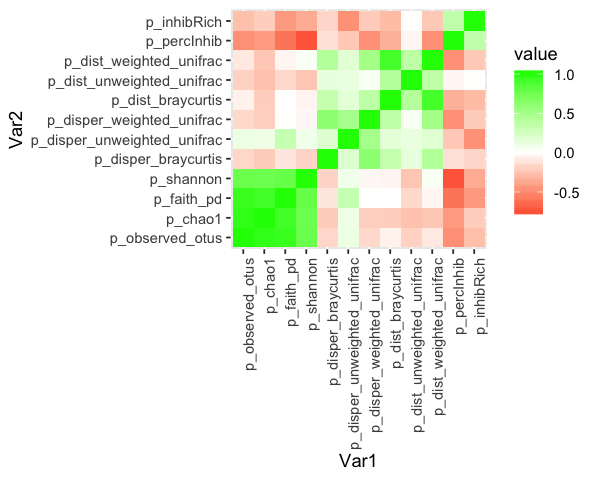

In [31]:
options(repr.plot.height=4, repr.plot.width=5)
melt(all_corr) %>%
ggplot() +
geom_tile(aes(x=Var1, y=Var2, fill=value)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  scale_fill_gradient2(low="red", mid="white", high="green")


What's strange is that percent inhibitory is more strongly (negatively) correlated to overall richness than inhibitory richness itself. So, as overall richness increases, the percent of OTUs that are inhibitory decreases faster than the richness of inhibitory OTUs.

Also, percent inhibitory is slightly negatively correlated with distance and dispersion (beta diversity)-- so higher percentages of inhibitory OTUs tend to have less movement over time or across individuals



### AIC to see which predictors most strongly explain PABD and Bd_load

In [32]:
# Looping through all metrics

df_AIC_PABD <- data.frame(metric=all_metrics, AIC=NA, stringsAsFactors = FALSE)
for ( m in all_metrics ) {
    temp_rename <- all_p %>%
    rename(dep=paste0(m)) 
    temp_glm <- glm(PABD ~ species*dep, data=temp_rename, family=binomial)
    df_AIC_PABD[match(m,all_metrics),"AIC"] <- AIC(temp_glm)
}
df_AIC_PABD <- rbind(df_AIC_PABD, c("species_only",AIC(glm(PABD ~ species, data=temp_rename, family=binomial))))
df_AIC_PABD[order(df_AIC_PABD$AIC),]


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

,metric,AIC
,<chr>,<chr>
12,p_inhibRich,20.7725887321913
6,p_disper_unweighted_unifrac,23.1922752297946
7,p_disper_weighted_unifrac,25.2121408519941
13,species_only,25.2763401026956
1,p_observed_otus,28.9427197039732
2,p_chao1,29.9465029131517
11,p_percInhib,30.4351253308626
3,p_faith_pd,30.5165610888028
8,p_dist_braycurtis,31.6919107797257


In [33]:
stepAIC(glm(PABD ~ species*p_inhibRich*p_disper_unweighted_unifrac, data=all_p, family=binomial))


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Start:  AIC=32
PABD ~ species * p_inhibRich * p_disper_unweighted_unifrac



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                                  Df   Deviance AIC
- species:p_inhibRich:p_disper_unweighted_unifrac  2 4.6892e-10  28
<none>                                               4.2226e-10  32


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=28
PABD ~ species + p_inhibRich + p_disper_unweighted_unifrac + 
    species:p_inhibRich + species:p_disper_unweighted_unifrac + 
    p_inhibRich:p_disper_unweighted_unifrac



Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                          Df   Deviance AIC
- species:p_disper_unweighted_unifrac      3 1.2392e-09  22
- species:p_inhibRich                      3 2.7025e-09  22
- p_inhibRich:p_disper_unweighted_unifrac  1 4.8349e-10  26
<none>                                       4.6892e-10  28


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=22
PABD ~ species + p_inhibRich + p_disper_unweighted_unifrac + 
    species:p_inhibRich + p_inhibRich:p_disper_unweighted_unifrac



Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                          Df   Deviance AIC
- species:p_inhibRich                      3 3.1854e-09  16
- p_inhibRich:p_disper_unweighted_unifrac  1 1.2491e-09  20
<none>                                       1.2392e-09  22


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=16
PABD ~ species + p_inhibRich + p_disper_unweighted_unifrac + 
    p_inhibRich:p_disper_unweighted_unifrac



Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                          Df Deviance    AIC
- p_inhibRich:p_disper_unweighted_unifrac  1   0.0000 14.000
<none>                                         0.0000 16.000
- species                                  4   9.8194 17.819


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=14
PABD ~ species + p_inhibRich + p_disper_unweighted_unifrac



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                              Df Deviance    AIC
<none>                             0.0000 14.000
- p_disper_unweighted_unifrac  1   2.7726 14.773
- species                      4  10.4370 16.437
- p_inhibRich                  1   7.2417 19.242



Call:  glm(formula = PABD ~ species + p_inhibRich + p_disper_unweighted_unifrac, 
    family = binomial, data = all_p)

Coefficients:
                (Intercept)                  speciesRhma  
                      993.1                        115.9  
                speciesOsse                  speciesRaca  
                     -100.1                       -269.0  
                speciesRapi                  p_inhibRich  
                     -549.4                      -1129.7  
p_disper_unweighted_unifrac  
                     -546.6  

Degrees of Freedom: 21 Total (i.e. Null);  15 Residual
Null Deviance:	    27.52 
Residual Deviance: 3.465e-09 	AIC: 14

In [34]:
df_AIC_Bdload <- data.frame(metric=all_metrics, AIC=NA,stringsAsFactors = FALSE)
for ( m in all_metrics ) {
    temp_rename <- all_p %>%
    rename(dep=paste0(m)) %>%
    filter(PABD>0)
    temp_glm <- glm(Bd_load+1 ~ species*dep, data=temp_rename, family=gaussian(link="log"))
    df_AIC_Bdload[match(m,all_metrics),"AIC"] <- AIC(temp_glm)
}
df_AIC_Bdload <- rbind(df_AIC_Bdload, c("species_only",AIC(glm(Bd_load+1 ~ species, data=temp_rename, family=gaussian(link="log")))))

df_AIC_Bdload[order(df_AIC_Bdload$AIC),]

,metric,AIC
,<chr>,<chr>
9,p_dist_unweighted_unifrac,53.1220468093596
10,p_dist_weighted_unifrac,53.7867371550161
11,p_percInhib,58.4215634608012
5,p_disper_braycurtis,63.146711743015
4,p_shannon,63.7306107732275
8,p_dist_braycurtis,64.4827722097003
13,species_only,64.9810606754233
7,p_disper_weighted_unifrac,70.9822742267272
2,p_chao1,71.1085904449168


In [35]:
stepAIC(lm(log(Bd_load+1) ~ species*p_dist_weighted_unifrac*p_percInhib, data=temp_rename))


Start:  AIC=-58.36
log(Bd_load + 1) ~ species * p_dist_weighted_unifrac * p_percInhib

                                              Df Sum of Sq      RSS     AIC
<none>                                                     0.054148 -58.361
- species:p_dist_weighted_unifrac:p_percInhib  1  0.042887 0.097035 -51.611



Call:
lm(formula = log(Bd_load + 1) ~ species * p_dist_weighted_unifrac * 
    p_percInhib, data = temp_rename)

Coefficients:
                                    (Intercept)  
                                         3.4530  
                                    speciesRhma  
                                        -1.3869  
                                    speciesOsse  
                                         1.7375  
                                    speciesRaca  
                                        -8.1309  
                        p_dist_weighted_unifrac  
                                        -1.3507  
                                    p_percInhib  
                                        -4.0284  
            speciesRhma:p_dist_weighted_unifrac  
                                         0.6546  
            speciesOsse:p_dist_weighted_unifrac  
                                        -3.3027  
            speciesRaca:p_dist_weighted_unifrac  
                      

# Following up AIC with linear regressions to see if significant

In [36]:
# Quick and dirty

anova_PABD_observed_otus <- Anova(glm(PABD ~ species*p_observed_otus, data=all_p, family=binomial))
anova_PABD_chao1 <- Anova(glm(PABD ~ species*p_chao1, data=all_p, family=binomial))
anova_PABD_faith_pd <- Anova(glm(PABD ~ species*p_faith_pd, data=all_p, family=binomial))
anova_PABD_shannon <- Anova(glm(PABD ~ species*p_shannon, data=all_p, family=binomial))

anova_PABD_dist_braycurtis <- Anova(glm(PABD ~ species*p_dist_braycurtis, data=all_p, family=binomial))
anova_PABD_dist_unweighted_unifrac <- Anova(glm(PABD ~ species*p_dist_unweighted_unifrac, data=all_p, family=binomial))
anova_PABD_dist_weighted_unifrac <- Anova(glm(PABD ~ species*p_dist_weighted_unifrac, data=all_p, family=binomial))


anova_PABD_disper_braycurtis <- Anova(glm(PABD ~ species*p_disper_braycurtis, data=all_p, family=binomial))
anova_PABD_disper_unweighted_unifrac <- Anova(glm(PABD ~ species*p_disper_unweighted_unifrac, data=all_p, family=binomial))
anova_PABD_disper_weighted_unifrac <- Anova(glm(PABD ~ species*p_disper_weighted_unifrac, data=all_p, family=binomial))


anova_PABD_inhibRich <- Anova(glm(PABD ~ species*p_inhibRich, data=all_p, family=binomial))
anova_PABD_percInhib <- Anova(glm(PABD ~ species*p_percInhib, data=all_p, family=binomial))


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [37]:
# Quick and dirty
all_p_noinfect <- all_p %>%
filter(PABD>0)

anova_Bdload_observed_otus <- anova(lm(log(Bd_load+1) ~ species*p_observed_otus, data=all_p_noinfect))
anova_Bdload_chao1 <- anova(lm(log(Bd_load+1) ~ species*p_chao1, data=all_p_noinfect))
anova_Bdload_faith_pd <- anova(lm(log(Bd_load+1) ~ species*p_faith_pd, data=all_p_noinfect))
anova_Bdload_shannon <- anova(lm(log(Bd_load+1) ~ species*p_shannon, data=all_p_noinfect))

anova_Bdload_dist_braycurtis <- anova(lm(log(Bd_load+1) ~ species*p_dist_braycurtis, data=all_p_noinfect))
anova_Bdload_dist_unweighted_unifrac <- anova(lm(log(Bd_load+1) ~ species*p_dist_unweighted_unifrac, data=all_p_noinfect))
anova_Bdload_dist_weighted_unifrac <- anova(lm(log(Bd_load+1) ~ species*p_dist_weighted_unifrac, data=all_p_noinfect))


anova_Bdload_disper_braycurtis <- anova(lm(log(Bd_load+1) ~ species*p_disper_braycurtis, data=all_p_noinfect))
anova_Bdload_disper_unweighted_unifrac <- anova(lm(log(Bd_load+1) ~ species*p_disper_unweighted_unifrac, data=all_p_noinfect))
anova_Bdload_disper_weighted_unifrac <- anova(lm(log(Bd_load+1) ~ species*p_disper_weighted_unifrac, data=all_p_noinfect))


anova_Bdload_inhibRich <- anova(lm(log(Bd_load+1) ~ species*p_inhibRich, data=all_p_noinfect))
anova_Bdload_percInhib <- anova(lm(log(Bd_load+1) ~ species*p_percInhib, data=all_p_noinfect))


In [38]:
cor.test(all_p$p_inhibRich, all_p$p_disper_unweighted_unifrac)
cor.test(all_p$p_percInhib, all_p$p_dist_weighted_unifrac)


	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_disper_unweighted_unifrac
t = -2.3667, df = 20, p-value = 0.02815
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.74286273 -0.05748054
sample estimates:
       cor 
-0.4677533 



	Pearson's product-moment correlation

data:  all_p$p_percInhib and all_p$p_dist_weighted_unifrac
t = -2.3985, df = 20, p-value = 0.02633
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.74565776 -0.06372335
sample estimates:
       cor 
-0.4726339 


Dispersion (unweighted phylogenetic) and inhibitory richness are inversingly correlated but are also both significant predictors of future infection probability (PABD).


In [45]:
# What is the variance explained by inhibitory richness?

summary(lm(log(Bd_load+1) ~ species*p_percInhib, data=all_p_noinfect))
anova(lm(log(Bd_load+1) ~ species*p_percInhib, data=all_p_noinfect))



Call:
lm(formula = log(Bd_load + 1) ~ species * p_percInhib, data = all_p_noinfect)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31922 -0.09352  0.00000  0.05120  0.34186 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.4237     0.2155  11.245 9.82e-06 ***
speciesRhma              -0.9512     0.4979  -1.910   0.0977 .  
speciesOsse             -23.0958    20.6598  -1.118   0.3005    
speciesRaca              -0.8634     0.6485  -1.331   0.2248    
p_percInhib              -1.4756     0.4968  -2.970   0.0208 *  
speciesRhma:p_percInhib   1.2437     1.2230   1.017   0.3430    
speciesOsse:p_percInhib  25.2539    22.6444   1.115   0.3016    
speciesRaca:p_percInhib   0.2111     1.0503   0.201   0.8464    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2401 on 7 degrees of freedom
Multiple R-squared:  0.9063,	Adjusted R-squared:  0.8125 
F-statistic: 9.669 on 7 and 7

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
species,3,3.2200086,1.07333621,18.615381,0.001026096
p_percInhib,1,0.5521686,0.55216857,9.576522,0.017454082
species:p_percInhib,3,0.1301864,0.04339545,0.752628,0.554797907
Residuals,7,0.4036100,0.05765857,NA,NA


# Part II: Does infection subsequently change microbiome metric?

In [34]:
# Filter out zeros
all_p_pred_infectonly <- all_p_pred %>%
filter(PABD>0)

In [35]:
# Presence/absence
# WITH zeros
print("Alpha diversity")
anova_observed_otus_PABD <- Anova(lm(p_observed_otus ~ species*PABD, data=all_p_pred), type=2)
anova_chao1_PABD <- Anova(lm(p_chao1 ~ species*PABD, data=all_p_pred), type=2)
anova_faith_pd_PABD <- Anova(lm(p_faith_pd ~ species*PABD, data=all_p_pred), type=2)
anova_shannon_PABD <- Anova(lm(p_shannon ~ species*PABD, data=all_p_pred), type=2)

print("Dist")
anova_dist_braycurtis_PABD <- Anova(lm(p_dist_braycurtis ~ species*PABD, data=all_p_pred), type=2)
anova_dist_unweighted_unifrac_PABD <- Anova(lm(p_dist_unweighted_unifrac ~ species*PABD, data=all_p_pred), type=2)
anova_dist_weighted_unifrac_PABD <- Anova(lm(p_dist_weighted_unifrac ~ species*PABD, data=all_p_pred), type=2)


print("Disper")
anova_disper_braycurtis_PABD <- Anova(lm(p_disper_braycurtis ~ species*PABD, data=all_p_pred), type=2)
anova_disper_unweighted_unifrac_PABD <- Anova(lm(p_disper_unweighted_unifrac ~ species*PABD, data=all_p_pred), type=2)
anova_disper_weighted_unifrac_PABD <- Anova(lm(p_disper_weighted_unifrac ~ species*PABD, data=all_p_pred), type=2)


print("inhibitory richness")
anova_inhibRich_PABD <- Anova(lm(p_inhibRich ~ species*PABD, data=all_p_pred), type=2)
print("inhibitory percent")
anova_percInhib_PABD <- Anova(lm(p_percInhib ~ species*PABD, data=all_p_pred), type=2)


[1] "Alpha diversity"


Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison


[1] "Dist"


Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison


[1] "Disper"


Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison


[1] "inhibitory richness"


Note: model has aliased coefficients
      sums of squares computed by model comparison


[1] "inhibitory percent"


Note: model has aliased coefficients
      sums of squares computed by model comparison


In [36]:
# Bd Load
# NO zeros

print("Alpha diversity")
anova_observed_otus_Bdload <- Anova(lm(p_observed_otus ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_chao1_Bdload <- Anova(lm(p_chao1 ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_faith_pd_Bdload <- Anova(lm(p_faith_pd ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_shannon_Bdload <- Anova(lm(p_shannon ~ species*Bd_load, data=all_p_pred_infectonly), type=2)

print("Dist")
anova_dist_braycurtis_Bdload <- Anova(lm(p_dist_braycurtis ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_dist_unweighted_unifrac_Bdload <- Anova(lm(p_dist_unweighted_unifrac ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_dist_weighted_unifrac_Bdload <- Anova(lm(p_dist_weighted_unifrac ~ species*Bd_load, data=all_p_pred_infectonly), type=2)


print("Disper")
anova_disper_braycurtis_Bdload <- Anova(lm(p_disper_braycurtis ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_disper_unweighted_unifrac_Bdload <- Anova(lm(p_disper_unweighted_unifrac ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
anova_disper_weighted_unifrac_Bdload <- Anova(lm(p_disper_weighted_unifrac ~ species*Bd_load, data=all_p_pred_infectonly), type=2)


print("inhibitory richness")
anova_inhibRich_Bdload <- Anova(lm(p_inhibRich ~ species*Bd_load, data=all_p_pred_infectonly), type=2)
print("inhibitory percent")
anova_percInhib_Bdload <- Anova(lm(p_percInhib ~ species*Bd_load, data=all_p_pred_infectonly), type=2)


[1] "Alpha diversity"
[1] "Dist"
[1] "Disper"
[1] "inhibitory richness"
[1] "inhibitory percent"


#### Creating table to save analytical results

In [37]:
stats_table_causeffect <- data.frame("Microbial Community Trait"=c(
                                                        "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Alpha diversity"
                                                       , "Dispersion"
                                                       , "Dispersion"
                                                       , "Dispersion"
                                                       , "Distance"
                                                       , "Distance"
                                                       , "Distance"
                                                       , "Inhibitory Richness"
                                                       , "Percent Inhibitory"
                                                       )
                          , "Metric"=c(
                                       "Observed otus"
                                      , "Chao1"
                                      , "Faith's PD"
                                      , "Shannon"
                                      , "Bray-curtis"
                                      , "Unweighted Unifrac"
                                      , "Weighted Unifrac"
                                      , "Bray-curtis"
                                      , "Unweighted Unifrac"
                                      , "Weighted Unifrac"
                                      , "Count"
                                      , "Proportion"
                                      )
                         , "Effect_on_PABD"=NA
                         , "Effect_on_Bd_load"=NA
                         , "Effect_of_PABD"=NA
                         , "Effect_of_Bd_load"=NA
                         )
# List of all tests
all_test_p <- c("observed_otus"
,"chao1"
,"faith_pd"
,"shannon"
,"disper_braycurtis"
,"disper_unweighted_unifrac"
,"disper_weighted_unifrac"
,"dist_braycurtis"
,"dist_unweighted_unifrac"
,"dist_weighted_unifrac"
,"inhibRich"
,"percInhib")
# Make these the rownames
rownames(stats_table_causeffect) <- all_test_p


In [38]:
# Copy this table to look at interactive effects separately
stats_table_causeffect_interactiononly <- stats_table_causeffect

In [39]:
# Extracting main effects
for ( t in all_test_p ) {
    for ( type in c("cause","effect")) {
        for ( test in c("PABD","Bdload") ) {
            if ( test=="Bdload") {
                varget<-"Bd_load"
            } else {
                varget<-test
            }
            # get fullgroup name
            if ( type=="cause") {
                full_group <- paste0("Effect_on_",varget)
            } else {
                full_group <- paste0("Effect_of_",varget)
            }
             
            if ( type=="effect") {
                temp_test <- get_stats(stat_test=get(paste0("anova_",t,"_",test)), variable=varget)

            } else if ( type=="cause" ) {
                temp_test <- get_stats(stat_test=get(paste0("anova_",test,"_",t)), variable=paste0("p_",t))
            }
        
        stats_table_causeffect[t,paste0(full_group)] <- temp_test$all
        
        }
    }
    
}

stats_table_causeffect
write.table(stats_table_causeffect, file="./6_Statistics/cause_effect_stats.txt", row.names = FALSE, col.names = TRUE, quote = FALSE, sep="\t")


,Microbial.Community.Trait,Metric,Effect_on_PABD,Effect_on_Bd_load,Effect_of_PABD,Effect_of_Bd_load
,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
observed_otus,Alpha diversity,Observed otus,"p=0.389, LR Chisq(1)=0.742","p=0.559, F(1,7)=0.375","p=0.959, F(1,15)=0.003","p=0.713, F(1,7)=0.147"
chao1,Alpha diversity,Chao1,"p=0.126, LR Chisq(1)=2.343","p=0.429, F(1,7)=0.706","p=0.862, F(1,15)=0.031","p=0.865, F(1,7)=0.031"
faith_pd,Alpha diversity,Faith's PD,"p=0.521, LR Chisq(1)=0.413","p=0.65, F(1,7)=0.225","p=0.457, F(1,15)=0.583","p=0.955, F(1,7)=0.003"
shannon,Alpha diversity,Shannon,"p=0.555, LR Chisq(1)=0.349","p=0.654, F(1,7)=0.22","p=0.595, F(1,15)=0.294","p=0.279, F(1,7)=1.38"
disper_braycurtis,Dispersion,Bray-curtis,"p=0.994, LR Chisq(1)=0","p=0.084, F(1,7)=4.067","p=0.815, F(1,15)=0.057","p=0.44, F(1,7)=0.671"
disper_unweighted_unifrac,Dispersion,Unweighted Unifrac,"p=0.005, LR Chisq(1)=8.035","p=0.632, F(1,7)=0.251","p=0.506, F(1,15)=0.464","p=0.922, F(1,7)=0.01"
disper_weighted_unifrac,Dispersion,Weighted Unifrac,"p=0.826, LR Chisq(1)=0.048","p=0.447, F(1,7)=0.649","p=0.498, F(1,15)=0.482","p=0.238, F(1,7)=1.668"
dist_braycurtis,Distance,Bray-curtis,"p=0.838, LR Chisq(1)=0.042","p=0.23, F(1,7)=1.73","p=0.066, F(1,15)=3.938","p=0.244, F(1,7)=1.621"
dist_unweighted_unifrac,Distance,Unweighted Unifrac,"p=0.472, LR Chisq(1)=0.517","p=0.02, F(1,7)=9.033","p=0.208, F(1,15)=1.729","p=0.378, F(1,7)=0.886"


In [40]:
# Extracting interaction effects
for ( t in all_test_p ) {
    for ( type in c("cause","effect")) {
        for ( test in c("PABD","Bdload") ) {
            if ( test=="Bdload") {
                varget<-"Bd_load"
            } else {
                varget<-paste0(test)
            }
            # get fullgroup name
            if ( type=="cause") {
                full_group <- paste0("Effect_on_",varget)
            } else {
                full_group <- paste0("Effect_of_",varget)
            }
             
            if ( type=="effect") {
                temp_test <- get_stats(stat_test=get(paste0("anova_",t,"_",test)), variable=paste0("species:",varget))

            } else if ( type=="cause" ) {
                temp_test <- get_stats(stat_test=get(paste0("anova_",test,"_",t)), variable=paste0("species:p_",t))
            }
        
        stats_table_causeffect_interactiononly[t,paste0(full_group)] <- temp_test$all
        
        }
    }
    
}

stats_table_causeffect_interactiononly
write.table(stats_table_causeffect_interactiononly, file="./6_Statistics/cause_effect_interactions_stats.txt", row.names = FALSE, col.names = TRUE, quote = FALSE, sep="\t")


,Microbial.Community.Trait,Metric,Effect_on_PABD,Effect_on_Bd_load,Effect_of_PABD,Effect_of_Bd_load
,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
observed_otus,Alpha diversity,Observed otus,"p=0.309, LR Chisq(3)=3.592","p=0.839, F(3,7)=0.279","p=0.057, F(1,15)=4.257","p=0.749, F(3,7)=0.413"
chao1,Alpha diversity,Chao1,"p=0.805, LR Chisq(3)=0.987","p=0.711, F(3,7)=0.472","p=0.025, F(1,15)=6.159","p=0.807, F(3,7)=0.326"
faith_pd,Alpha diversity,Faith's PD,"p=0.504, LR Chisq(3)=2.347","p=0.825, F(3,7)=0.3","p=0.107, F(1,15)=2.945","p=0.67, F(3,7)=0.541"
shannon,Alpha diversity,Shannon,"p=0.967, LR Chisq(3)=0.265","p=0.344, F(3,7)=1.312","p=0.279, F(1,15)=1.259","p=0.162, F(3,7)=2.318"
disper_braycurtis,Dispersion,Bray-curtis,"p=0.748, LR Chisq(3)=1.222","p=0.603, F(3,7)=0.658","p=0.508, F(1,15)=0.461","p=0.398, F(3,7)=1.138"
disper_unweighted_unifrac,Dispersion,Unweighted Unifrac,"p=0.562, LR Chisq(3)=2.049","p=0.76, F(3,7)=0.396","p=0.289, F(1,15)=1.209","p=0.855, F(3,7)=0.256"
disper_weighted_unifrac,Dispersion,Weighted Unifrac,"p=0.046, LR Chisq(3)=8.016","p=0.46, F(3,7)=0.967","p=0.673, F(1,15)=0.186","p=0.934, F(3,7)=0.139"
dist_braycurtis,Distance,Bray-curtis,"p=0.673, LR Chisq(3)=1.542","p=0.362, F(3,7)=1.251","p=0.816, F(1,15)=0.056","p=0.345, F(3,7)=1.308"
dist_unweighted_unifrac,Distance,Unweighted Unifrac,"p=0.803, LR Chisq(3)=0.995","p=0.346, F(3,7)=1.304","p=0.777, F(1,15)=0.083","p=0.233, F(3,7)=1.809"


### What if we include zeros on "effects of infection"?
(printed here, but not saved as file)


In [65]:
# Bd Load
# NO zeros

print("Alpha diversity")
Anova(lm(p_observed_otus ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_chao1 ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_faith_pd ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_shannon ~ species*Bd_load, data=all_p_pred), type=2)

print("Dist")
Anova(lm(p_dist_braycurtis ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_dist_unweighted_unifrac ~ species*Bd_load, data=all_p_pred), type=2)
 Anova(lm(p_dist_weighted_unifrac ~ species*Bd_load, data=all_p_pred), type=2)


print("Disper")
Anova(lm(p_disper_braycurtis ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_disper_unweighted_unifrac ~ species*Bd_load, data=all_p_pred), type=2)
Anova(lm(p_disper_weighted_unifrac ~ species*Bd_load, data=all_p_pred), type=2)


print("inhibitory richness")
Anova(lm(p_inhibRich ~ species*Bd_load, data=all_p_pred), type=2)
print("inhibitory percent")
Anova(lm(p_percInhib ~ species*Bd_load, data=all_p_pred), type=2)


[1] "Alpha diversity"


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.456224908,4,3.53348874,0.03671534
Bd_load,0.001507008,1,0.04668746,0.83228447
species:Bd_load,0.048734155,3,0.50326520,0.68663665
Residuals,0.419622379,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,4.046815e-01,4,3.618377265,0.03416138
Bd_load,3.931605e-05,1,0.001406146,0.97065717
species:Bd_load,7.012814e-02,3,0.836048662,0.49781731
Residuals,3.634820e-01,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.3372787770,4,2.212726322,0.1242602
Bd_load,0.0002724119,1,0.007148661,0.9339075
species:Bd_load,0.0677959901,3,0.593036511,0.6305235
Residuals,0.4953870772,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.59193585,4,5.8851042,0.006274246
Bd_load,0.02793549,1,1.1109533,0.311071487
species:Bd_load,0.05812202,3,0.7704757,0.530838401
Residuals,0.32689167,13,NA,NA


[1] "Dist"


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.095991811,4,0.79006706,0.5520233
Bd_load,0.001435455,1,0.04725843,0.8312792
species:Bd_load,0.162209099,3,1.78009722,0.2004907
Residuals,0.394869498,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,1.044586e-01,4,1.2910806558,0.3237804
Bd_load,3.186089e-06,1,0.0001575168,0.9901769
species:Bd_load,3.533407e-02,3,0.5822927738,0.6370443
Residuals,2.629507e-01,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.030744442,4,0.28120467,0.8849256
Bd_load,0.001192545,1,0.04363053,0.8377799
species:Bd_load,0.050860502,3,0.62026217,0.6142437
Residuals,0.355326380,13,NA,NA


[1] "Disper"


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.08825117,4,0.7182268,0.5944510
Bd_load,0.02510562,1,0.8172822,0.3824235
species:Bd_load,0.03048371,3,0.3307864,0.8032534
Residuals,0.39933944,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.09243349,4,0.87566397,0.5047054
Bd_load,0.00161147,1,0.06106472,0.8086806
species:Bd_load,0.02267019,3,0.28635318,0.8344173
Residuals,0.34306406,13,NA,NA


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.03485978,4,0.408069,0.7996826
Bd_load,0.02677414,1,1.253673,0.2831130
species:Bd_load,0.04472850,3,0.698123,0.5696515
Residuals,0.27763515,13,NA,NA


[1] "inhibitory richness"


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,0.393214803,4,5.1166135,0.01065293
Bd_load,0.007098905,1,0.3694912,0.55375297
species:Bd_load,0.019467550,3,0.3377558,0.79838381
Residuals,0.249764441,13,NA,NA


[1] "inhibitory percent"


Note: model has aliased coefficients
      sums of squares computed by model comparison


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
species,1.3012329220,4,20.08201669,1.797794e-05
Bd_load,0.0004876189,1,0.03010182,8.649318e-01
species:Bd_load,0.0378657065,3,0.77917872,5.263389e-01
Residuals,0.2105867684,13,NA,NA


#### Plotting effect of microbial community on infection risk

In [41]:
Anova(glm(PABD ~ species+p_inhibRich, data=all_p, family=binomial), type=3)


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
species,17.92298,4,0.0012776113
p_inhibRich,12.50375,1,0.0004061357


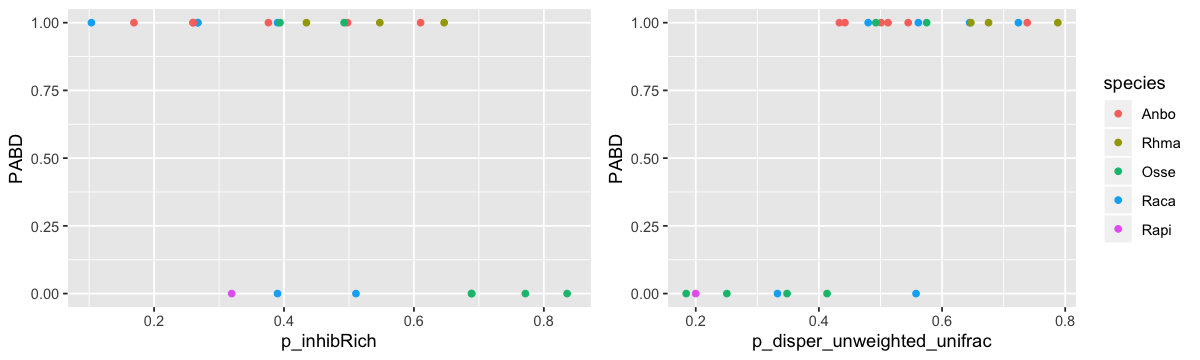

In [42]:
options(repr.plot.height=3, repr.plot.width=10)
gg_PABD_inhibRich <-all_p %>%
ggplot(aes(y=PABD)) +
       geom_point(aes(x=p_inhibRich, col=species), show.legend=FALSE)
gg_PABD_disper_unweighted_unifrac <- all_p %>%
ggplot(aes(y=PABD)) +
       geom_point(aes(x=p_disper_unweighted_unifrac,col=species))
grid.arrange(gg_PABD_inhibRich,gg_PABD_disper_unweighted_unifrac, nrow=1)

In [63]:

pearson_inhibRich_observed_otus <- cor.test(all_p$p_inhibRich, all_p$p_observed_otus, method="pearson")
pearson_inhibRich_chao1 <- cor.test(all_p$p_inhibRich, all_p$p_chao1, method="pearson")
pearson_inhibRich_faithPD <- cor.test(all_p$p_inhibRich, all_p$p_faith_pd, method="pearson")
pearson_inhibRich_shannon <- cor.test(all_p$p_inhibRich, all_p$p_shannon, method="pearson")
pearson_inhibRich_percInhib <- cor.test(all_p$p_inhibRich, all_p$p_percInhib, method="pearson")

pearson_inhibRich_observed_otus
pearson_inhibRich_chao1
pearson_inhibRich_faithPD
pearson_inhibRich_shannon
pearson_inhibRich_percInhib

capture.output(pearson_inhibRich_observed_otus
            , file="./6_Statistics/pearson_inhibRich_observed_otus.txt"
            )
capture.output(pearson_inhibRich_chao1
            , file="./6_Statistics/pearson_inhibRich_chao1.txt"
            )
capture.output(pearson_inhibRich_faithPD
            , file="./6_Statistics/pearson_inhibRich_faithPD.txt"
            )
capture.output(pearson_inhibRich_shannon
            , file="./6_Statistics/pearson_inhibRich_shannon.txt"
            )
capture.output(pearson_inhibRich_percInhib
            , file="./6_Statistics/pearson_inhibRich_percInhib.txt"
            )


	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_observed_otus
t = -1.2695, df = 20, p-value = 0.2189
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6229589  0.1678632
sample estimates:
       cor 
-0.2730712 



	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_chao1
t = -0.95225, df = 20, p-value = 0.3523
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5790281  0.2338835
sample estimates:
       cor 
-0.2082609 



	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_faith_pd
t = -2.1617, df = 20, p-value = 0.04294
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.72397010 -0.01664327
sample estimates:
      cor 
-0.435198 



	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_shannon
t = -1.7206, df = 20, p-value = 0.1008
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.67803948  0.07368312
sample estimates:
       cor 
-0.3590803 



	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_percInhib
t = 1.6903, df = 20, p-value = 0.1065
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.07997107  0.67460749
sample estimates:
      cor 
0.3535581 


In [64]:

pearson_inhibRich_disper_UWU <- cor.test(all_p$p_inhibRich, all_p$p_disper_unweighted_unifrac, method="pearson")

pearson_inhibRich_disper_UWU
capture.output(pearson_inhibRich_disper_UWU
            , file="./6_Statistics/pearson_inhibRich_disper_UWU.txt")


	Pearson's product-moment correlation

data:  all_p$p_inhibRich and all_p$p_disper_unweighted_unifrac
t = -2.3667, df = 20, p-value = 0.02815
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.74286273 -0.05748054
sample estimates:
       cor 
-0.4677533 


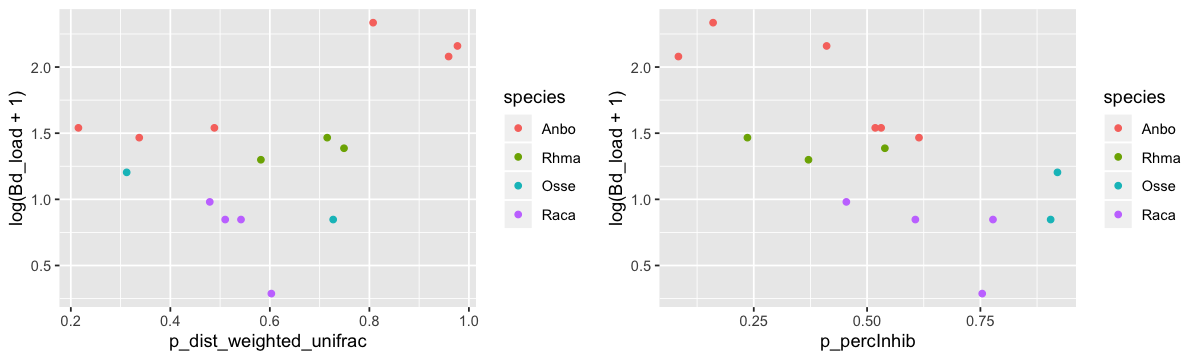

In [43]:
options(repr.plot.height=3, repr.plot.width=10)
gg_dist_Bd_load <- all_p %>%
filter(PABD>0) %>%
ggplot(aes(y=log(Bd_load+1))) +
       geom_point(aes(x=p_dist_weighted_unifrac, col=species))

gg_percInhib_Bd_load <- all_p %>%
filter(PABD>0) %>%
ggplot(aes(y=log(Bd_load+1))) +
       geom_point(aes(x=p_percInhib, col=species))
grid.arrange(gg_dist_Bd_load,gg_percInhib_Bd_load, nrow=1)

#### Plotting all other traits

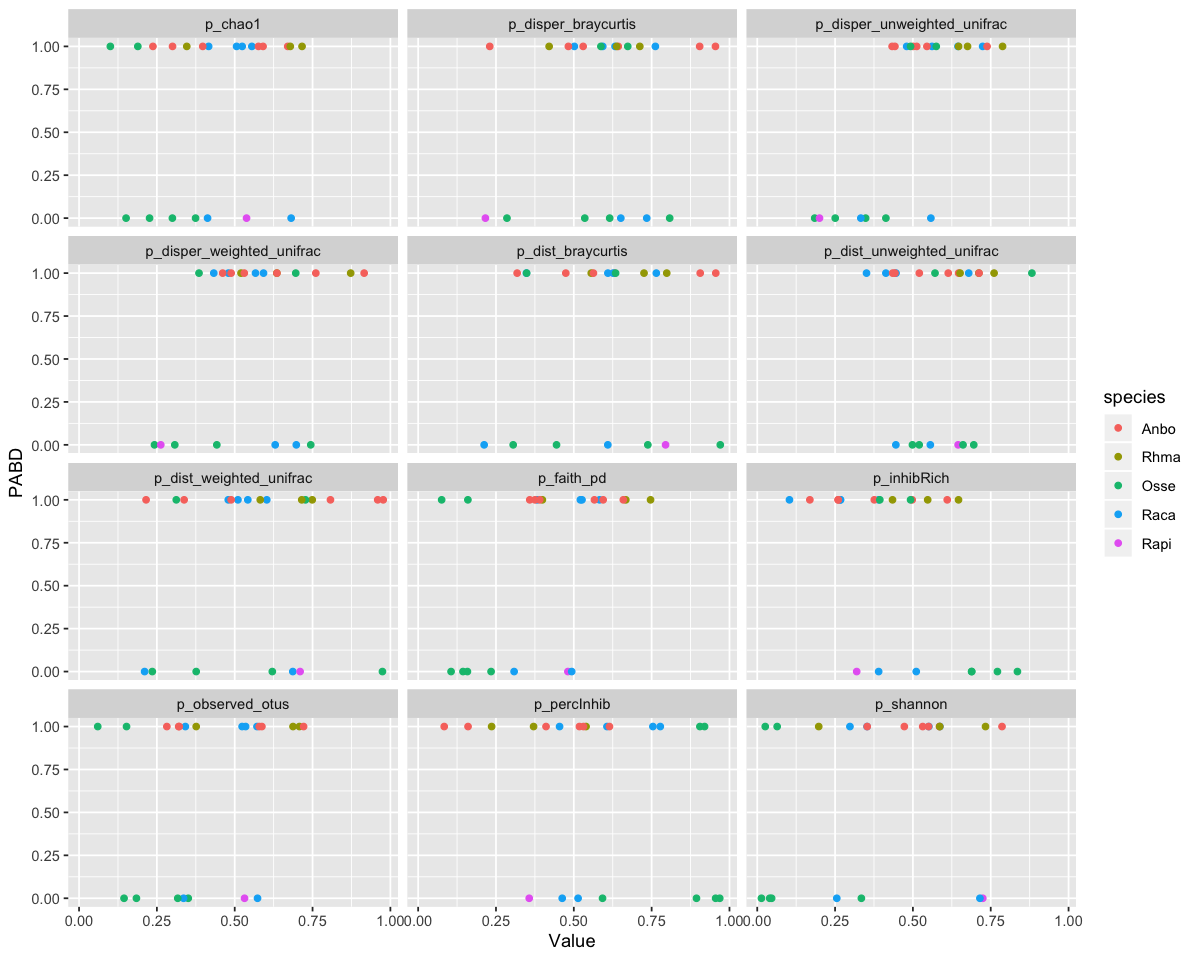

In [44]:
# Effect of traits on risk of infection (PABD)
options(repr.plot.height=8, repr.plot.width=10)
all_p %>%
dplyr::select(indivID, species, p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, Bd_load, PABD) %>%
gather(p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, key=Metric, value=Value) %>%
ggplot() +
geom_point(aes(x=Value, y=PABD, col=species)) +
facet_wrap(~Metric, ncol=3)

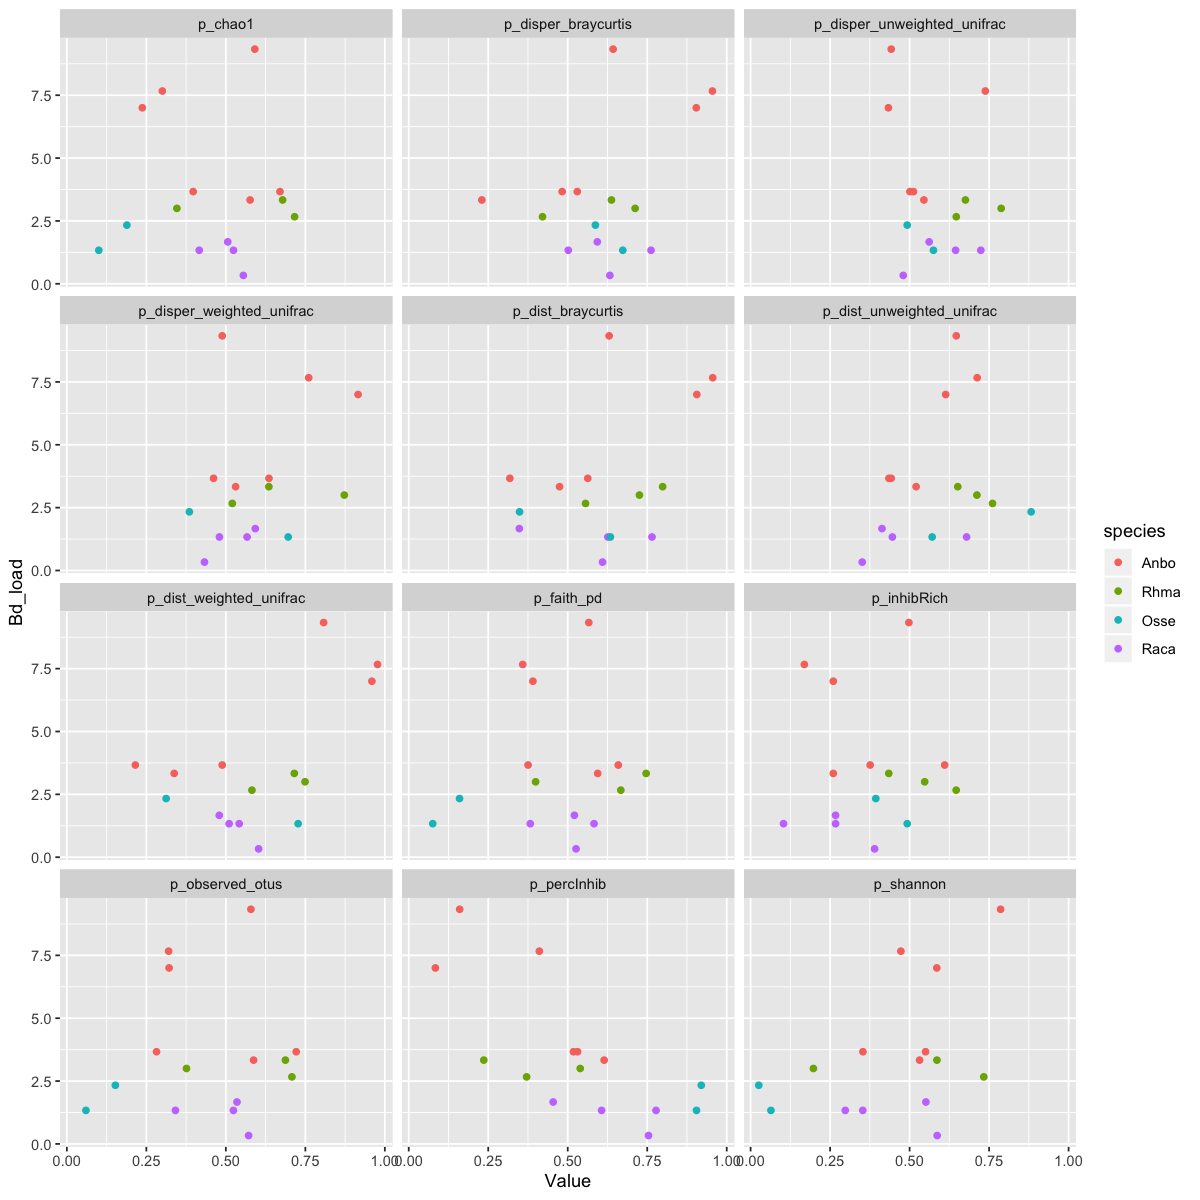

In [45]:
# Effect of traits on future Bd load
options(repr.plot.height=10, repr.plot.width=10)
all_p_noinfect %>%
dplyr::select(indivID, species, p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, Bd_load, PABD) %>%
gather(p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, key=Metric, value=Value) %>%
ggplot() +
geom_point(aes(x=Value, y=Bd_load, col=species)) +
facet_wrap(~Metric, ncol=3)

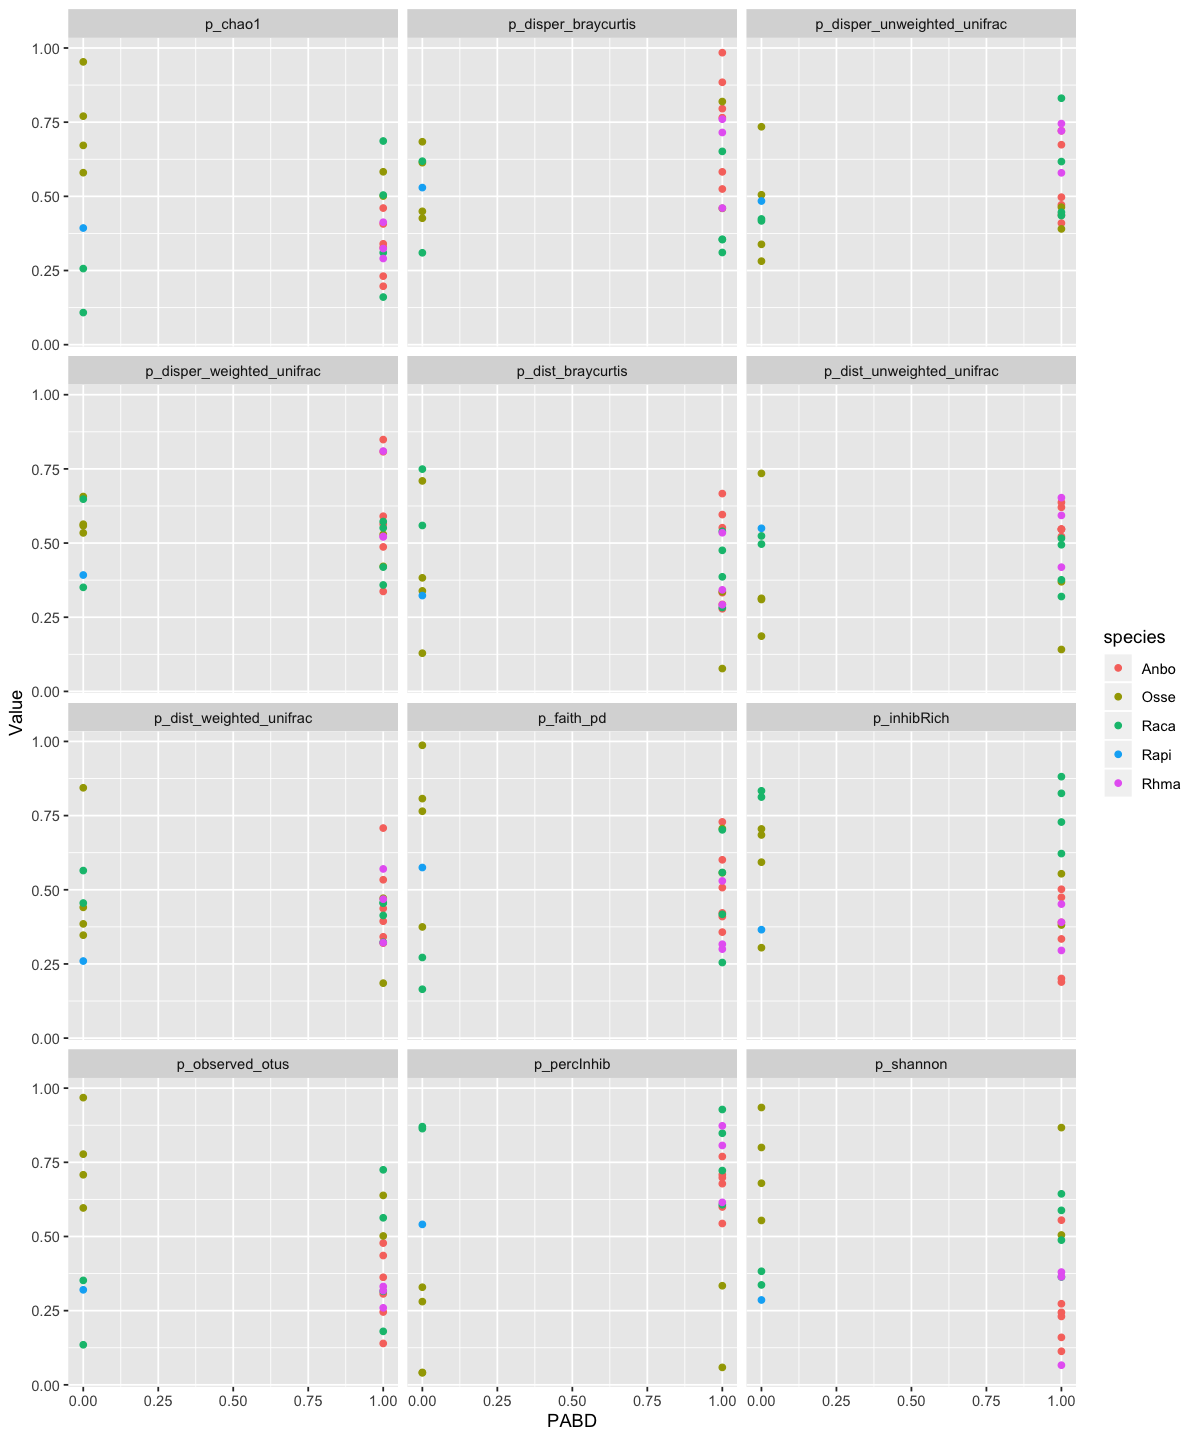

In [46]:
# Effect of PABD on traits
options(repr.plot.height=12, repr.plot.width=10)
all_p_pred %>%
dplyr::select(indivID, species, p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, Bd_load, PABD) %>%
gather(p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, key=Metric, value=Value) %>%
ggplot() +
geom_point(aes(x=PABD, y=Value, col=species)) +
facet_wrap(~Metric, ncol=3)

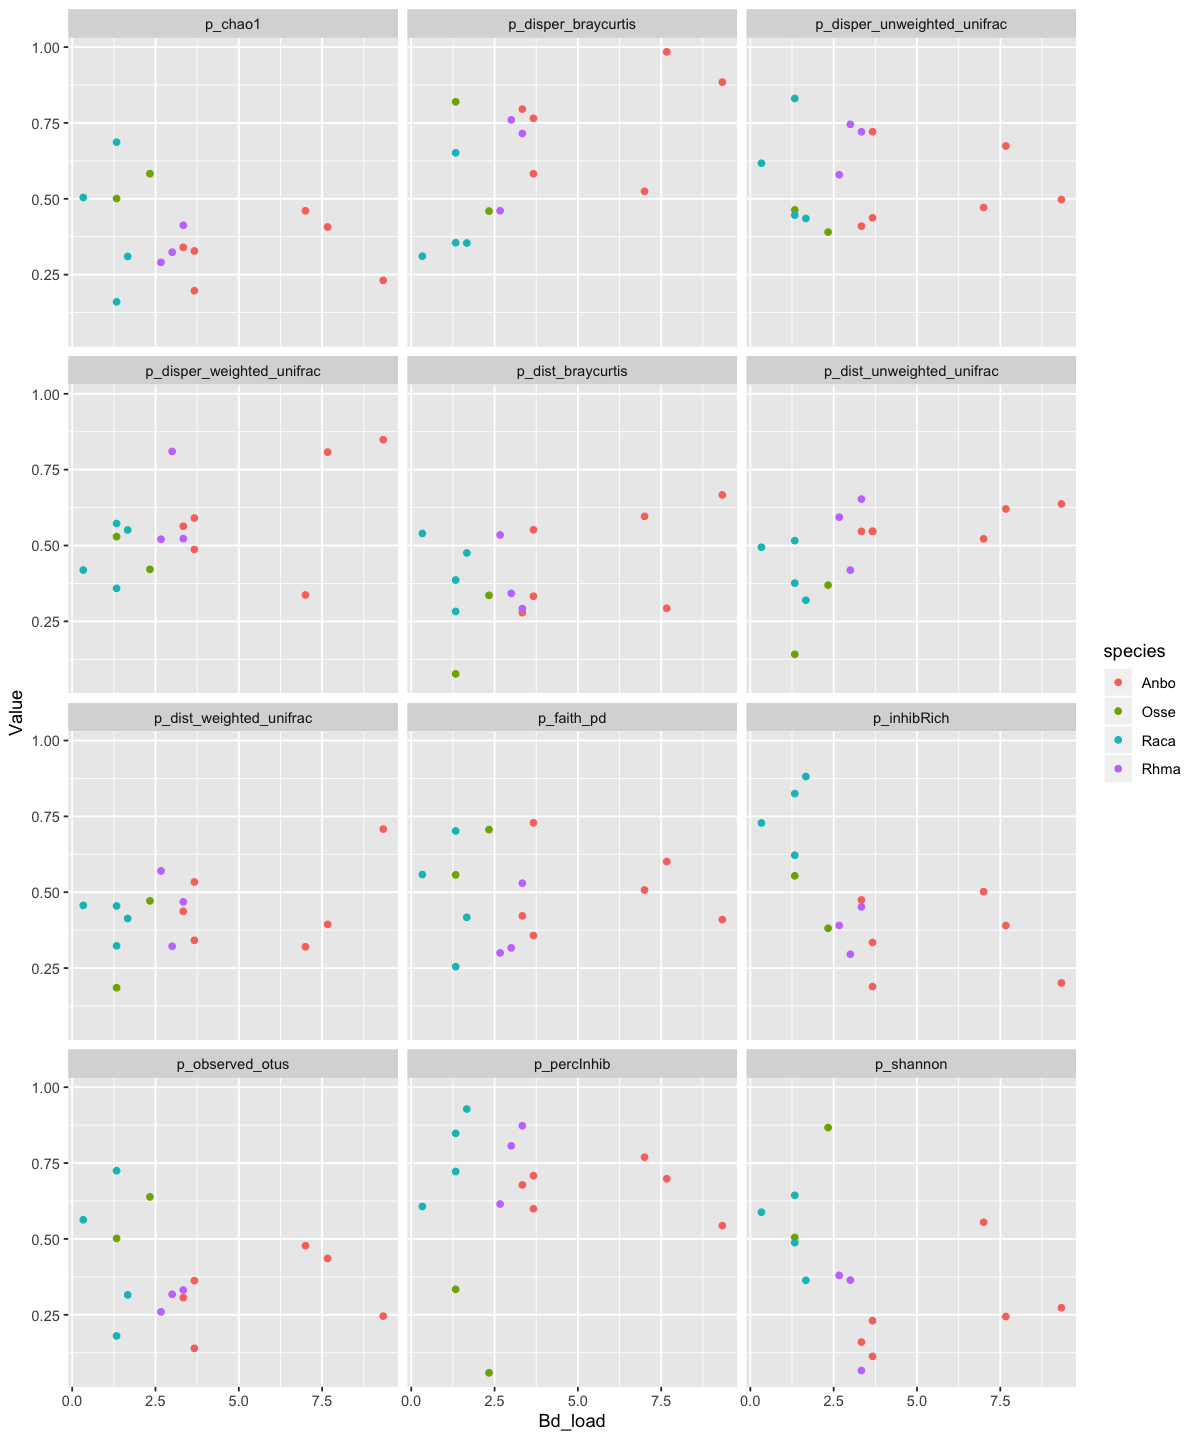

In [47]:
# Effect of Bd load on traits
options(repr.plot.height=12, repr.plot.width=10)
all_p_pred_infectonly %>%
dplyr::select(indivID, species, p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, Bd_load, PABD) %>%
gather(p_observed_otus, p_chao1, p_shannon, p_faith_pd
       , p_disper_braycurtis, p_disper_unweighted_unifrac, p_disper_weighted_unifrac
      , p_dist_braycurtis, p_dist_unweighted_unifrac, p_dist_weighted_unifrac
      , p_percInhib, p_inhibRich, key=Metric, value=Value) %>%
ggplot() +
geom_point(aes(x=Bd_load, y=Value, col=species)) +
facet_wrap(~Metric, ncol=3)

In [48]:
print("observed_otus")
anova(lm(p_observed_otus ~ Bd_load, data=all_p_pred_infectonly))
print("chao1")
anova(lm(p_chao1 ~ Bd_load, data=all_p_pred_infectonly))
print("shannon")
anova(lm(p_shannon ~ Bd_load, data=all_p_pred_infectonly))
print("faith pd")
anova(lm(p_faith_pd ~ Bd_load, data=all_p_pred_infectonly))
print("dist_bc")
anova(lm(p_dist_braycurtis ~ Bd_load, data=all_p_pred_infectonly))
print("dist_uwu")
anova(lm(p_dist_unweighted_unifrac ~ Bd_load, data=all_p_pred_infectonly))
print("dist_wu")
anova(lm(p_dist_weighted_unifrac ~ Bd_load, data=all_p_pred_infectonly))
print("disper_bc")
anova(lm(p_disper_braycurtis ~ Bd_load, data=all_p_pred_infectonly))
print("disper_uwu")
anova(lm(p_disper_unweighted_unifrac ~ Bd_load, data=all_p_pred_infectonly))
print("disper_wu")
anova(lm(p_disper_weighted_unifrac ~ Bd_load, data=all_p_pred_infectonly))
print("percinhib")
anova(lm(p_percInhib ~ Bd_load, data=all_p_pred_infectonly))
print("inhibRich")
anova(lm(p_inhibRich ~ Bd_load, data=all_p_pred_infectonly))




[1] "observed_otus"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.02213283,0.02213283,0.7769432,0.394083
Residuals,13,0.37033189,0.02848707,NA,NA


[1] "chao1"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.01982118,0.01982118,0.9278082,0.3530092
Residuals,13,0.27772480,0.02136345,NA,NA


[1] "shannon"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.08480322,0.08480322,1.860532,0.1957144
Residuals,13,0.59254133,0.04558010,NA,NA


[1] "faith pd"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.0001237349,0.0001237349,0.004912101,0.9451916
Residuals,13,0.3274675401,0.0251898108,NA,NA


[1] "dist_bc"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.05381761,0.05381761,2.410618,0.1445125
Residuals,13,0.29022802,0.02232523,NA,NA


[1] "dist_uwu"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.08559103,0.08559103,6.025078,0.02896133
Residuals,13,0.18467534,0.01420580,NA,NA


[1] "dist_wu"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.0282033,0.0282033,1.946545,0.1863382
Residuals,13,0.1883557,0.0144889,NA,NA


[1] "disper_bc"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.2159731,0.21597312,6.931685,0.02067671
Residuals,13,0.4050459,0.03115737,NA,NA


[1] "disper_uwu"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.0003861858,0.0003861858,0.0172152,0.8976206
Residuals,13,0.2916269142,0.0224328396,NA,NA


[1] "disper_wu"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.09247272,0.09247272,4.728446,0.04872375
Residuals,13,0.25423684,0.01955668,NA,NA


[1] "percinhib"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.001139996,0.001139996,0.02173356,0.88506
Residuals,13,0.681892213,0.052453247,NA,NA


[1] "inhibRich"


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Bd_load,1,0.2114840,0.2114840,6.861106,0.02121144
Residuals,13,0.4007068,0.0308236,NA,NA


### Effect on exposure versus infection on composition


In [67]:
adonis2(weighted_unifrac_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:Bd_load, data=mf_alt_filt_final, by="term")
adonis2(unweighted_unifrac_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:Bd_load, data=mf_alt_filt_final, by="term")
adonis2(braycurtis_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:Bd_load, data=mf_alt_filt_final, by="term")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,12.0450455,0.239962823,48.616300,0.001
time,1,2.5990642,0.051778865,41.961448,0.001
species:time,4,1.9827712,0.039501003,8.002876,0.001
Bd_exposure:prepost,3,0.7225346,0.014394419,3.888399,0.001
species:Bd_exposure:prepost,12,2.0958687,0.041754145,2.819787,0.001
Bd_exposure:prepost:Bd_load,1,0.4618453,0.009200936,7.456413,0.001
Residual,489,30.2883356,0.603407808,NA,NA
Total,514,50.1954651,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,20.6400092,0.169421005,29.463628,0.001
time,1,3.8558026,0.031649886,22.016644,0.001
species:time,4,4.4888688,0.036846334,6.407864,0.001
Bd_exposure:prepost,3,1.8637336,0.015298231,3.547308,0.001
species:Bd_exposure:prepost,12,5.0701333,0.041617573,2.412540,0.001
Bd_exposure:prepost:Bd_load,1,0.2690098,0.002208134,1.536047,0.029
Residual,489,85.6391854,0.702958838,NA,NA
Total,514,121.8267426,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,53.601537,0.26807117,57.388740,0.001
time,1,8.576672,0.04289352,36.730620,0.001
species:time,4,9.927152,0.04964752,10.628553,0.001
Bd_exposure:prepost,3,3.531178,0.01766007,5.040897,0.001
species:Bd_exposure:prepost,12,9.310482,0.04656344,3.322771,0.001
Bd_exposure:prepost:Bd_load,1,0.823145,0.00411670,3.525217,0.001
Residual,489,114.182466,0.57104758,NA,NA
Total,514,199.952632,1.00000000,NA,NA


In [68]:
adonis2(weighted_unifrac_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:PABD, data=mf_alt_filt_final, by="term")
adonis2(unweighted_unifrac_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:PABD, data=mf_alt_filt_final, by="term")
adonis2(braycurtis_filt ~ species + time + species:time + Bd_exposure:prepost + species:Bd_exposure:prepost + Bd_exposure:prepost:PABD, data=mf_alt_filt_final, by="term")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,12.0450455,0.23996282,48.131894,0.001
time,1,2.5990642,0.05177887,41.543349,0.001
species:time,4,1.9827712,0.03950100,7.923136,0.001
Bd_exposure:prepost,3,0.7225346,0.01439442,3.849656,0.001
species:Bd_exposure:prepost,12,2.0958687,0.04175414,2.791691,0.001
Bd_exposure:prepost:PABD,1,0.1570189,0.00312815,2.509785,0.020
Residual,489,30.5931619,0.60948059,NA,NA
Total,514,50.1954651,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,20.6400092,0.169421005,29.438814,0.001
time,1,3.8558026,0.031649886,21.998101,0.001
species:time,4,4.4888688,0.036846334,6.402467,0.001
Bd_exposure:prepost,3,1.8637336,0.015298231,3.544321,0.001
species:Bd_exposure:prepost,12,5.0701333,0.041617573,2.410508,0.001
Bd_exposure:prepost:PABD,1,0.1968232,0.001615599,1.122914,0.230
Residual,489,85.7113719,0.703551372,NA,NA
Total,514,121.8267426,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,4,53.601537,0.268071172,57.210786,0.001
time,1,8.576672,0.042893521,36.616724,0.001
species:time,4,9.927152,0.049647520,10.595595,0.001
Bd_exposure:prepost,3,3.531178,0.017660075,5.025266,0.001
species:Bd_exposure:prepost,12,9.310482,0.046563437,3.312467,0.001
Bd_exposure:prepost:PABD,1,0.467981,0.002340459,1.997970,0.010
Residual,489,114.537630,0.572823816,NA,NA
Total,514,199.952632,1.000000000,NA,NA
